# --- EVALUATING THE FRENCH MARGINAL MIX ---

Reference : M. Biéron, J. Le Dréau, B. Haas. Development of a Unit Commitment model to assess the marginal technologies reacting to demand response events. Under review (2022)

Copyright (C) ENGIE SA - ENGIE Lab CRIGEN - La Rochelle University/LaSIE - All Rights Reserved

 - Proprietary and confidential
 - Subject to French law on copyright
 - Unauthorized copying of this file, via any medium is strictly prohibited: https://crigen.myengie.com/copyright

Any request for authorization of use should be addressed by email to “mvalo.bvt@engie.com” with the subject “Copyright Statement in Source Code”

In [ ]:
# JLD: change 2018 to year in more spots?

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import datetime
import scipy
import scipy.stats as st
from sklearn.metrics import mean_absolute_error as mae
import scipy.optimize

In [21]:
# user-defined function
def RMSE(mesures,modele):
    y=np.sqrt(sum((mesures-modele)**2)/len(mesures))
    return y

In [2]:
#Year of the simulation
year=2018

In [3]:
#Start and end date of the simulation
sdate=datetime.datetime(year,1,8,6,0,0)
edate=datetime.datetime(year,12,30,5,30,0)

s_date=datetime.datetime(year,1,1)
e_date=datetime.datetime(year,12,24)

idx_Simu=pd.date_range(start=sdate, end=edate, freq='30min')

In [4]:
#Number of virtual powerplants corresponding to electricity exchanges
n_EP=11

In [5]:
#Definition of lists and series
technos=['Ech. physiques','Nucleaire','Gaz - CCGT','Charbon', 'Fioul', 'Gaz - TAC']
list_colors=['royalblue','gold','orangered','silver','mediumorchid','darkred']
labels_technos=['Exchanges','Nuclear','CCGT','Coal', 'Oil', 'Gas turbines', 'Compensation of the hydroelectric generation']
list_color=pd.Series(list_colors+['None'],index=labels_technos)
list_hatch=pd.Series(['']*(len(labels_technos)-1)+['///'],index=labels_technos)
list_patch = [mpatches.Patch(facecolor=list_color[tech],  hatch=list_hatch[tech], label=tech) for tech in labels_technos]
liste_pays=['Germany (DE)','Portugal (PT)', 'Switzerland (CH)', 'Netherlands (NL)', 'Denmark (DK)',  'Slovenia (SI)', 'Croatia (HR)', 'Ireland (IE)', 'Czech Republic (CZ)', 'Spain (ES)', 'Others']
liste_others=['Austria (AT)', 'Belgium (BE)',    'Greece (GR)',  'Italy (IT)', 'Luxembourg (LU)', 'Malta (MT)', 'Montenegro (ME)', 'Norway (NO)', 'Poland (PL)',    'Sweden (SE)',  'United Kingdom (UK)']

# 1/ Loading input data

Consumption and electricity generation from the French TSO (RTE)

In [7]:
df = pd.read_excel("Input data\eCO2mix_RTE_Annuel-Definitif_"+str(year)+".xlsx",encoding='utf-8',engine='openpyxl')

In [8]:
newDate = df['Date'].map(str).str.replace("00:00:00", "") + df['Heures'].map(str)
df.index = pd.to_datetime(newDate, format="%Y-%m-%d %H:%M:%S")
df_resampled = df.resample('30T').mean()

In [9]:
df_resampled['Dispatchable'] = df_resampled['Consommation']-df_resampled['Eolien']-df_resampled['Solaire']-df_resampled['Hydraulique - Fil de l?eau + eclusee']-df_resampled['Bioenergies']-df_resampled['Gaz - Cogen.']-df_resampled['Fioul - Cogen.']
df_resampled['Hydraulique2'] = df_resampled['Hydraulique - STEP turbinage']+df_resampled['Hydraulique - Lacs']+df_resampled['Pompage']
df_resampled['Gaz - CCGT'] =df_resampled['Gaz - CCG']+df_resampled['Gaz - Autres']
df_resampled['Fioul'] =df_resampled['Fioul - TAC']+df_resampled['Fioul - Autres']

Net transfer capacity (NTC) from ENTSOE

In [11]:
df_ntc = pd.read_excel("Input data\Interconnexion\capacite_interconnexion_2017-2018-2019.xlsx",encoding='utf-8',engine='openpyxl')

In [12]:
df_ntc.index=pd.date_range(start='2017-01-09', end='2020-1-5 23:00:00', freq='1h')

In [13]:
for column in list(df_ntc)[2:len(list(df_ntc))]:
    df_ntc[column]=df_ntc[column].map(str).str.replace("*", "nan").astype(float)

In [14]:
df_ntc_export=df_ntc.loc[:,[i for i in list(df_ntc) if i.startswith('Export')]].sum(axis=1)
for date in df_ntc.index[0:len(df_ntc.index)-1]:
    if df_ntc_export[date+datetime.timedelta(hours=1)]==0:
        df_ntc_export[date+datetime.timedelta(hours=1)]=df_ntc_export[date]
df_ntc_export=df_ntc_export.resample('30T').pad()


Electricity exchanges in Europe

In [17]:
df_int = pd.read_csv("Input data\Interconnexion\interco_ex_eq.csv", index_col = 0)+pd.read_csv("Input data\Interconnexion\interco_imp_eq.csv",encoding='utf-8', index_col = 0)
df_int.index = pd.to_datetime(df_int.index, format="%Y-%m-%d %H:%M:%S")
df_interco=df_int.resample('30T').pad()
df_interco['Others']=df_interco.loc[:,liste_others].sum(axis=1)

Constraint on the virtual powerplants representing electrity exchanges calculated with the german residual consumption (from preprocessing)

In [18]:
lim_all=pd.read_csv('Input data\Interconnexion\limit_RC_ger.csv', header = None,index_col = 0, names = ['date',  'lim'], parse_dates=True).loc[:,'lim']

Availability of the discretized groups of technologies (from preprocessing)

In [19]:
# JLD: j'en compte 10 tranches d'interconnection
df_dispo = pd.read_csv('Input data\dispo_discret_'+str(year)+'_'+str(n_EP)+'.csv',parse_dates=True , index_col = 0)

Merit orders calibrated for 2018 (from preprocessing)
- MO1 scheduling
- MO2 dispatch

In [20]:
MO1=pd.read_csv('Input data\Merit-order\MO1_'+str(year)+'_'+str(n_EP)+'.csv',parse_dates=True, index_col = 0, header = None).index.values
MO2=pd.read_csv('Input data\Merit-order\MO2_'+str(year)+'_'+str(n_EP)+'.csv',parse_dates=True, index_col = 0, header = None).index.values


# 2/ Unit-commitment model

### a. Model definition 

In [22]:
#List with the daily time-step corresponding to the minimum residual consumption between 0am and 6am 
list_t_min_date=pd.Series([df_resampled['Dispatchable'].loc[date:date+datetime.timedelta(hours=6)].idxmin() for date in pd.date_range(start=datetime.datetime(year,1,1), end=datetime.datetime(year,12,31))], index=pd.date_range(start=datetime.datetime(year,1,1), end=datetime.datetime(year,12,31)))

Sub-model with the Scheduling and Dispatch
   - input: residual consumption (CR)
   - output: dispatch of the residual consumption (MODEL_Dispatch) but also the result of the scheduling (Pmin, Pmax). The result of the scheduling will be reused for the calculation of the marginal mix for DSM events shorter than one day.

In [23]:
# JLD: missing input (MO1, MO2, df_dispo) + define size input/output in description
def mod_thermique(CR):
    Technologies_Dispatch_up_2=MO2
    Technologies_Scheduling2=MO1
    MODEL_Dispatch=pd.DataFrame(columns=Technologies_Dispatch_up_2 ,index= pd.date_range(start=list_t_min_date[datetime.datetime(year,1,1)]+datetime.timedelta(minutes=30), end=list_t_min_date[datetime.datetime(year,12,31)], freq='30min'), dtype = float)
    Adjustment_Dispatch=pd.Series(index=Technologies_Dispatch_up_2)
    Residuel=0
    P_min=pd.DataFrame(0,columns=Technologies_Dispatch_up_2, index=MODEL_Dispatch.index)
    P_min['CCGT_1']=pd.Series(200, index=P_min.index)
    P_max=pd.DataFrame(columns=Technologies_Dispatch_up_2, index=MODEL_Dispatch.index)
    P_min['Nucleaire - Base']=df_dispo['Nucleaire - Base']
    for i in range (1,n_EP):
        P_min['Ech. p_'+repr(i)] =np.minimum(df_dispo['Ech. p_'+repr(i)],np.maximum(np.zeros(len(df_dispo)),lim_all-P_min.loc[:,['Ech. p_'+repr(j) for j in range(1,i)]].sum(axis=1))) 
    for date in pd.date_range(start=datetime.datetime(year,1,1), end=datetime.datetime(year,12,30)):
        for i in range(len(Technologies_Scheduling2)):
            P_temp=max(CR[list_t_min_date[date]+datetime.timedelta(minutes=30): list_t_min_date[date+datetime.timedelta( days = 1)]]-P_max.loc[list_t_min_date[date]+datetime.timedelta(minutes=30): list_t_min_date[date+datetime.timedelta( days = 1)],Technologies_Scheduling2[0:i]].sum(axis = 1)-P_min.loc[list_t_min_date[date]+datetime.timedelta(minutes=30): list_t_min_date[date+datetime.timedelta( days = 1)],Technologies_Scheduling2[i+1:len(Technologies_Scheduling2)+1]].sum(axis = 1))           
            for hour in pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'):              
                P_max.at[hour,Technologies_Scheduling2[i]]=max(0,P_min.at[hour,Technologies_Scheduling2[i]],min(P_temp,df_dispo.at[hour,Technologies_Scheduling2[i]]))
        P_min.loc[pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'),['Ech. p_'+repr(i) for i in range(1,n_EP)]]=pd.DataFrame(0,columns=['Ech. p_'+repr(i) for i in range(1,n_EP)],index=pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'))
        for i in range (n_EP-1,0,-1):
            P_min.loc[list_t_min_date[date]+datetime.timedelta(minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)],'Ech. p_'+repr(i)] =np.minimum(P_max.loc[pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'),'Ech. p_'+repr(i)],np.maximum(np.zeros(len(P_min['Ech. p_'+repr(i)][list_t_min_date[date]+datetime.timedelta(minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)] ])),lim_all[list_t_min_date[date]+datetime.timedelta(minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)] ]-P_min.loc[pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'),['Ech. p_'+repr(j) for j in range(i+1,n_EP)]].sum(axis=1)))
        P_min.loc[list_t_min_date[date]+datetime.timedelta(minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)],'Charbon_1']=np.minimum(300*np.ones(len(P_min['Charbon_1'][list_t_min_date[date]+datetime.timedelta(minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)]])),P_max.loc[pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'),'Charbon_1'])        
        for hour in pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'):
            Residuel=CR[hour]
            List_P_min=P_min.loc[hour,:].values
            List_P_max=P_max.loc[hour,:].values
            for i in range(len(Technologies_Dispatch_up_2)):              
                MODEL_Dispatch.at[hour, Technologies_Dispatch_up_2[i]]=max(min(Residuel-sum(List_P_min[i+1:len(Technologies_Dispatch_up_2)+1]), List_P_max[i]),List_P_min[i])
                Residuel=Residuel-MODEL_Dispatch.at[hour, Technologies_Dispatch_up_2[i]]                                  
    return MODEL_Dispatch, P_min , P_max

Submodel for the hydroelectric powerplants
   - input: residual consumption (CR)
   - output: the hydro electric generation (hydro) and the minimum value for hydroelectric generation (P_min_hydro). The minimum will be reused for the calculation of the marginal mix.

In [25]:
#List with the 2 daily time-step corresponding to the minimum residual consumption between 0am and 6am and between 12am and 6pm
list_t_min_12=pd.Series([df_resampled['Dispatchable'].loc[date:date+datetime.timedelta(hours=6)].idxmin() for date in pd.date_range(start=datetime.datetime(year,1,1), end=datetime.datetime(year,12,31), freq='12h')], index=pd.date_range(start=datetime.datetime(year,1,1), end=datetime.datetime(year,12,31), freq='12h'))

In [26]:
#JLD: set name
alpha=pd.concat([pd.Series(0.45, index=pd.date_range(start=datetime.datetime(year,1,1,5,30),end=list_t_min_12[datetime.datetime(year,2,1)], freq='30min')),pd.Series(0.61, index=pd.date_range(start=list_t_min_12[datetime.datetime(year,2,1)]+datetime.timedelta(minutes=30), end=list_t_min_12[datetime.datetime(year,3,5)], freq='30min')),pd.Series(0.45, index=pd.date_range(start=list_t_min_12[datetime.datetime(year,3,5)]+datetime.timedelta(minutes=30), end=datetime.datetime(year,12,31,4,30), freq='30min'))])

In [30]:
#JLD input: missing list... + alpha + why CR_df? df_hydro
def f_hydro(CR_df,df_hydro):
    CR_mean_hebdo=pd.Series([np.mean(CR_df[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(days=7)]]) for i in pd.date_range(start=datetime.datetime(year,1,1,0,0), end=datetime.datetime(year,12,30,0,0), freq='7d') for date in pd.date_range(start=list_t_min_12[i]+datetime.timedelta(minutes=30), end=list_t_min_12[i+datetime.timedelta(days=7)], freq='30min')], index=[date for i in pd.date_range(start=datetime.datetime(year,1,1,0,0), end=datetime.datetime(year,12,30,0,0), freq='7d') for date in pd.date_range(start=list_t_min_12[i]+datetime.timedelta(minutes=30), end=list_t_min_12[i+datetime.timedelta(days=7)], freq='30min')], dtype = float)
    CR_mean_12h=pd.Series([np.mean((CR_df-CR_mean_hebdo)[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(hours=12)]]) for i in list_t_min_12.index[0:len(list_t_min_12)-1] for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], index=[date for i in list_t_min_12.index[0:len(list_t_min_12)-1] for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], dtype = float)
    CR_st=CR_df-CR_mean_hebdo-CR_mean_12h
    hydro_mean_hebdo=pd.Series([np.mean(df_hydro[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(days=7)]]) for i in pd.date_range(start=datetime.datetime(year,1,1,0,0), end=datetime.datetime(year,12,30,0,0), freq='7d') for date in pd.date_range(start=list_t_min_12[i]+datetime.timedelta(minutes=30), end=list_t_min_12[i+datetime.timedelta(days=7)], freq='30min')], index=[date for i in pd.date_range(start=datetime.datetime(year,1,1,0,0), end=datetime.datetime(year,12,30,0,0), freq='7d') for date in pd.date_range(start=list_t_min_12[i]+datetime.timedelta(minutes=30), end=list_t_min_12[i+datetime.timedelta(days=7)], freq='30min')], dtype = float)
    hydro_temp=hydro_mean_hebdo+0.19*CR_mean_12h+np.multiply(alpha,CR_st)
    mod_min_24h=pd.Series([min(hydro_temp[list_t_min_date[i]+datetime.timedelta(minutes=30):list_t_min_date[i+datetime.timedelta(hours=24)]]) for i in list_t_min_date.index[0:len(list_t_min_date)-1] for date in pd.date_range(list_t_min_date[i]+datetime.timedelta(minutes=30),list_t_min_date[i+datetime.timedelta(hours=24)],freq='30min')], index=[date for i in list_t_min_date.index[0:len(list_t_min_date)-1] for date in pd.date_range(list_t_min_date[i]+datetime.timedelta(minutes=30),list_t_min_date[i+datetime.timedelta(hours=24)],freq='30min')], dtype = float)
    mod_min_hebdo=pd.Series([np.mean(mod_min_24h[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(days=7)]]) for i in pd.date_range(start=datetime.datetime(year,1,1,0,0), end=datetime.datetime(year,12,30,0,0), freq='7d') for date in pd.date_range(start=list_t_min_12[i]+datetime.timedelta(minutes=30), end=list_t_min_12[i+datetime.timedelta(days=7)], freq='30min')], index=[date for i in pd.date_range(start=datetime.datetime(year,1,1,0,0), end=datetime.datetime(year,12,30,0,0), freq='7d') for date in pd.date_range(start=list_t_min_12[i]+datetime.timedelta(minutes=30), end=list_t_min_12[i+datetime.timedelta(days=7)], freq='30min')], dtype = float)
    P_min_hydro=(np.maximum(-0.85*df_dispo.loc[mod_min_hebdo.index,'Hydraulique - STEP turbinage'],mod_min_hebdo))
    sat=np.minimum(0,hydro_temp-P_min_hydro)
    corr_w=pd.Series([np.mean((sat)[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(hours=12)]]) for i in list_t_min_12.index[0:len(list_t_min_12)-1] for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], index=[date for i in list_t_min_12.index[0:len(list_t_min_12)-1] for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], dtype = float)
    corr_hebdo=pd.Series([np.mean(sat[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(days=7)]]) for i in pd.date_range(start=datetime.datetime(year,1,1,0,0), end=datetime.datetime(year,12,30,0,0), freq='7d') for date in pd.date_range(start=list_t_min_12[i]+datetime.timedelta(minutes=30), end=list_t_min_12[i+datetime.timedelta(days=7)], freq='30min')], index=[date for i in pd.date_range(start=datetime.datetime(year,1,1,0,0), end=datetime.datetime(year,12,30,0,0), freq='7d') for date in pd.date_range(start=list_t_min_12[i]+datetime.timedelta(minutes=30), end=list_t_min_12[i+datetime.timedelta(days=7)], freq='30min')], dtype = float)    
    hydro=np.maximum(P_min_hydro,hydro_temp)+((alpha-0.19)/alpha)*corr_w+(0.19/alpha)*corr_hebdo
    return hydro, P_min_hydro

Global model for scheduling and dispatch & hydro
   - input: residual consumption (CR)
   - output:

In [31]:
#JLD: why CO2?
def contenuCO2(CR):
    MODEL_Dispatch=pd.DataFrame(columns=['Hydraulique2', 'Nucleaire', 'Charbon', 'Ech. physiques', 'Gaz - CCGT', 'Gaz - TAC', 'Fioul'])
    #Dispatch of the hydroelectric generation
    MODEL_Dispatch.loc[:,'Hydraulique2'], P_min_hydro=f_hydro(CR, df_resampled['Hydraulique2'])
    #Scheduling and Dispatch
    [MODEL_D,P_minF,P_maxF]=mod_thermique(CR-MODEL_Dispatch['Hydraulique2']+df_ntc_export)
    MODEL_Dispatch.loc[:,'Charbon']=MODEL_D['Charbon_1']+MODEL_D['Charbon_2']+MODEL_D['Charbon_3']+MODEL_D['Charbon_4']+MODEL_D['Charbon_5']
    MODEL_Dispatch.loc[:,'Gaz - CCGT']=MODEL_D['CCGT_1']+MODEL_D['CCGT_2']+MODEL_D['CCGT_3']+MODEL_D['CCGT_4']+MODEL_D['CCGT_5']+MODEL_D['CCGT_6']+MODEL_D['CCGT_7']+MODEL_D['CCGT_8']+MODEL_D['CCGT_9']+MODEL_D['CCGT_10']
    MODEL_Dispatch.loc[:,'Nucleaire']=MODEL_D['Nucleaire - Base']+MODEL_D['Nucleaire_1']+MODEL_D['Nucleaire_2']+MODEL_D['Nucleaire_3']+MODEL_D['Nucleaire_4']+MODEL_D['Nucleaire_5']+MODEL_D['Nucleaire_6']
    MODEL_Dispatch.loc[:,'Ech. physiques']=MODEL_D.loc[:,['Ech. p_'+repr(i) for i in range(1,n_EP)]].sum(axis=1)-df_ntc_export
    MODEL_Dispatch.loc[:,'Fioul']=MODEL_D['Fioul - TAC']+MODEL_D['Fioul - Autres']
    MODEL_Dispatch.loc[:,'Gaz - TAC']=MODEL_D['Gaz - TAC']
    return MODEL_D,MODEL_Dispatch,P_minF,P_maxF, P_min_hydro

### b. Results: comparison unit-commitment model / TSO data for the year 2018

Running the model

In [32]:
# JLD: long, add information on running time or print (around 5 minutes)
[MODEL_D,MODEL_Dispatch,P_min,P_max, P_min_hydro]=contenuCO2(df_resampled['Dispatchable'])

C:\Users\jledreau\AppData\Local\conda\conda\envs\Python_3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [33]:
df_dispo['Charbon']=df_dispo['Charbon_1']+df_dispo['Charbon_2']+df_dispo['Charbon_3']+df_dispo['Charbon_4']+df_dispo['Charbon_5']
df_dispo['Gaz - CCGT']=df_dispo['CCGT_1']+df_dispo['CCGT_2']+df_dispo['CCGT_3']+df_dispo['CCGT_4']+df_dispo['CCGT_5']+df_dispo['CCGT_6']+df_dispo['CCGT_7']+df_dispo['CCGT_8']+df_dispo['CCGT_9']+df_dispo['CCGT_10']
df_dispo['Nucleaire']=df_dispo['Nucleaire - Base']+df_dispo['Nucleaire_1']+df_dispo['Nucleaire_2']+df_dispo['Nucleaire_3']+df_dispo['Nucleaire_4']+df_dispo['Nucleaire_5']+df_dispo['Nucleaire_6']
df_dispo['Ech. physiques']=df_dispo.loc[:,['Ech. p_'+repr(i) for i in range(1,n_EP)]].sum(axis=1)-df_ntc_export


Plotting figures

In [34]:
register_matplotlib_converters()

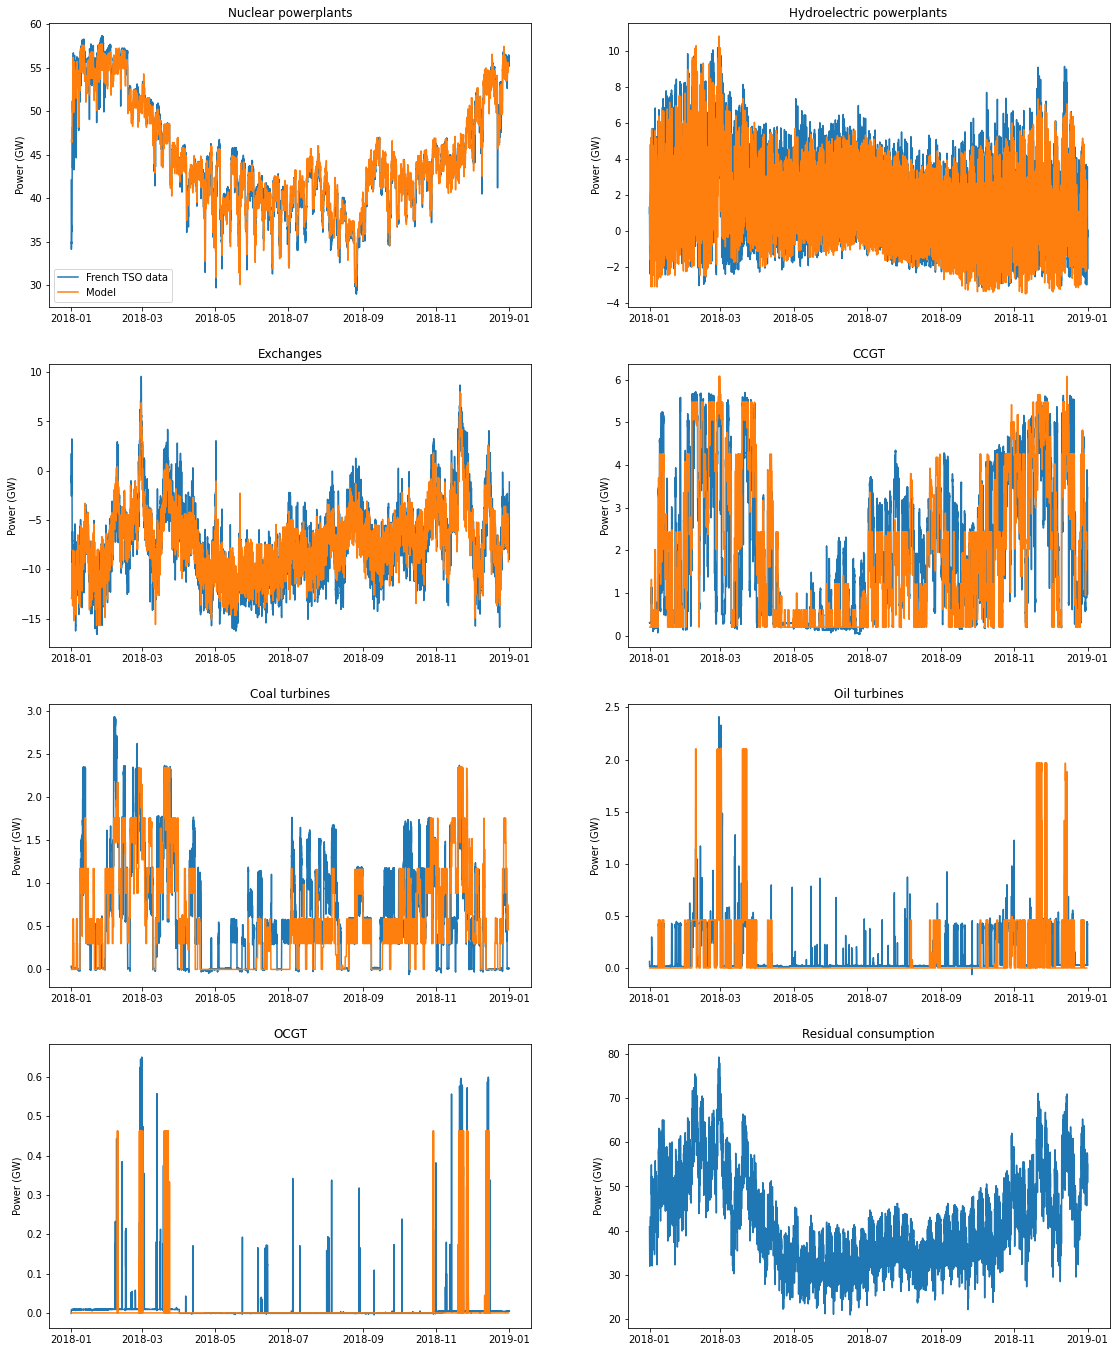

In [35]:
# Modeled and observed power generation for each type of powerplant in 2018

fig,weeks=plt.subplots(ncols=2, nrows=4, figsize=(19, 24))

weeks[0][0].plot(df_resampled['Nucleaire']/1000, label='French TSO data')
weeks[0][0].plot((MODEL_Dispatch['Nucleaire']/1000), label='Model')
weeks[0][0].set_ylabel('Power (GW)')
weeks[0][0].set_title('Nuclear powerplants')
weeks[0][0].legend()

weeks[0][1].plot(df_resampled['Hydraulique2']/1000)
weeks[0][1].plot((MODEL_Dispatch['Hydraulique2']/1000))
weeks[0][1].set_ylabel('Power (GW)')
weeks[0][1].set_title('Hydroelectric powerplants')

weeks[1][0].plot(df_resampled['Ech. physiques']/1000)
weeks[1][0].plot((MODEL_Dispatch['Ech. physiques']/1000))
weeks[1][0].set_ylabel('Power (GW)')
weeks[1][0].set_title('Exchanges')

weeks[1][1].plot(df_resampled['Gaz - CCGT']/1000)
weeks[1][1].plot((MODEL_Dispatch['Gaz - CCGT']/1000))
weeks[1][1].set_ylabel('Power (GW)')
weeks[1][1].set_title('CCGT')

weeks[2][0].plot(df_resampled['Charbon']/1000)
weeks[2][0].plot((MODEL_Dispatch['Charbon']/1000))
weeks[2][0].set_ylabel('Power (GW)')
weeks[2][0].set_title('Coal turbines')

weeks[2][1].plot(df_resampled['Fioul']/1000)
weeks[2][1].plot((MODEL_Dispatch['Fioul']/1000))
weeks[2][1].set_ylabel('Power (GW)')
weeks[2][1].set_title('Oil turbines')

weeks[3][0].plot(df_resampled['Gaz - TAC']/1000, label='French TSO data')
weeks[3][0].plot((MODEL_Dispatch['Gaz - TAC']/1000), label='Model')
weeks[3][0].set_ylabel('Power (GW)')
weeks[3][0].set_title('OCGT')

weeks[3][1].plot((df_resampled['Dispatchable']/1000))
weeks[3][1].set_ylabel('Power (GW)')
weeks[3][1].set_title('Residual consumption')


fig.savefig('Results\Plot\Mix année.svg', format='svg')

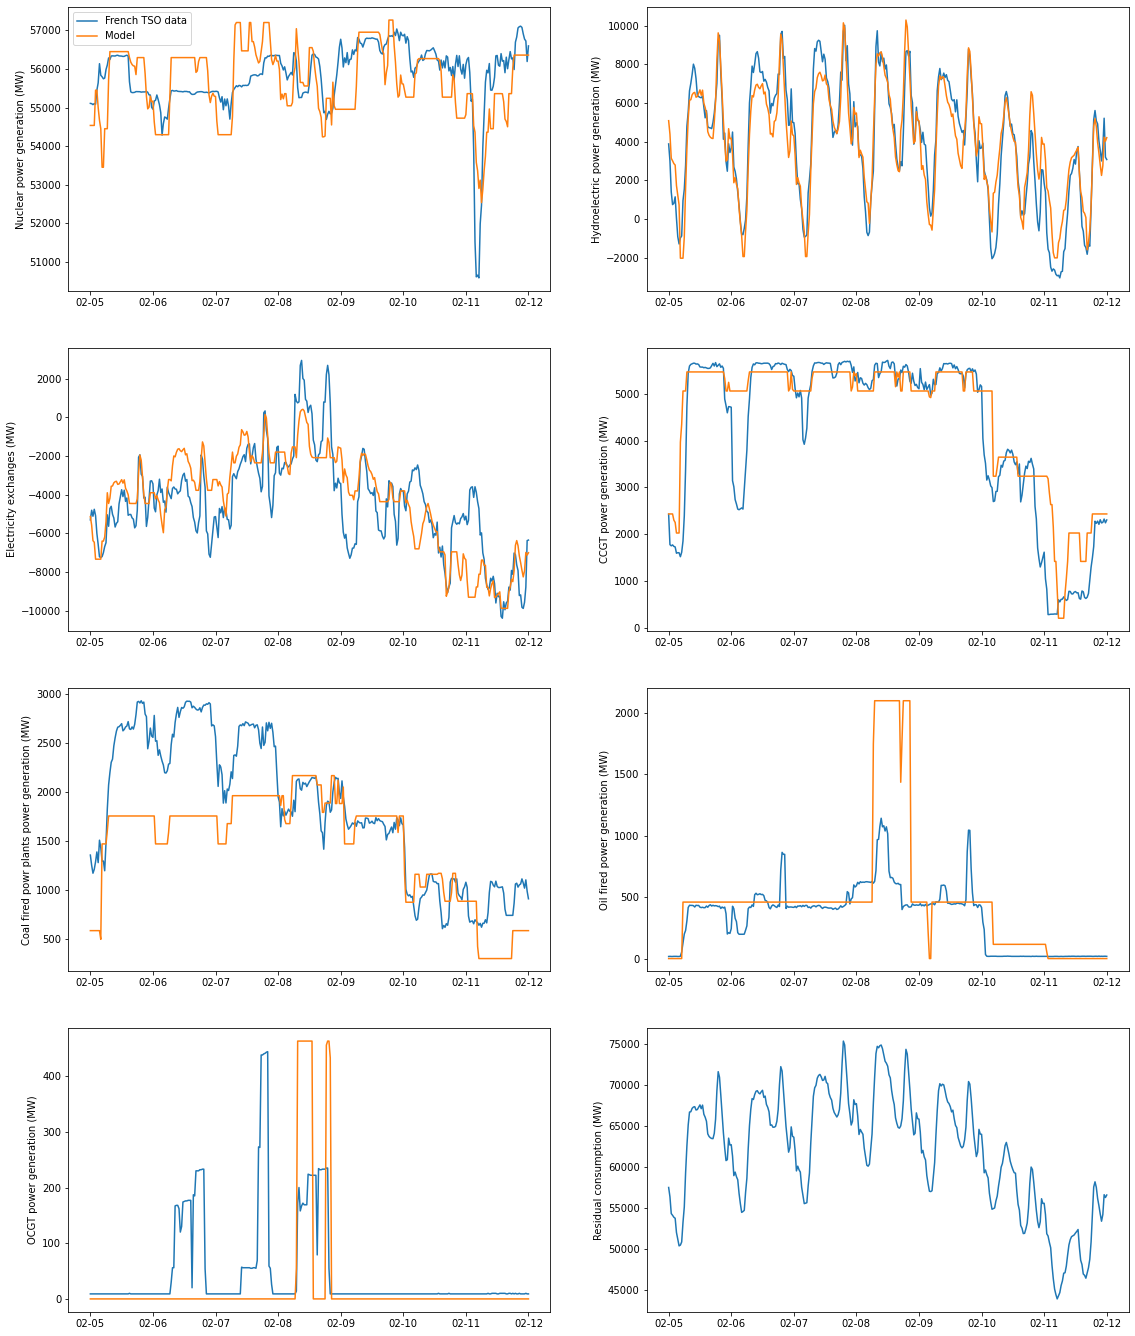

In [36]:
# Modeled and observed power generation for each type of powerplant for one week of February year

fig,weeks=plt.subplots(ncols=2, nrows=4, figsize=(19, 24))

weeks[0][0].plot(df_resampled['Nucleaire'][datetime.date(year,2,5):datetime.date(year,2,12)], label='French TSO data')
weeks[0][0].plot((MODEL_Dispatch['Nucleaire'][datetime.date(year,2,5):datetime.date(year,2,12)]), label='Model')
weeks[0][0].set_ylabel('Nuclear power generation (MW)')
weeks[0][0].legend()
weeks[0][0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

weeks[0][1].plot(df_resampled['Hydraulique2'][datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[0][1].plot((MODEL_Dispatch['Hydraulique2'])[datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[0][1].set_ylabel('Hydroelectric power generation (MW)')
weeks[0][1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

weeks[1][0].plot(df_resampled['Ech. physiques'][datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[1][0].plot((MODEL_Dispatch['Ech. physiques'])[datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[1][0].set_ylabel('Electricity exchanges (MW)')
weeks[1][0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

weeks[1][1].plot(df_resampled['Gaz - CCGT'][datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[1][1].plot((MODEL_Dispatch['Gaz - CCGT'])[datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[1][1].set_ylabel('CCGT power generation (MW)')
weeks[1][1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

weeks[2][0].plot(df_resampled['Charbon'][datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[2][0].plot((MODEL_Dispatch['Charbon'])[datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[2][0].set_ylabel('Coal fired powr plants power generation (MW)')
weeks[2][0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

weeks[2][1].plot(df_resampled['Fioul'][datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[2][1].plot((MODEL_Dispatch['Fioul'])[datetime.date(year,2,5):datetime.date(year,2,12)])
weeks[2][1].set_ylabel('Oil fired power generation (MW)')
weeks[2][1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

weeks[3][0].plot(df_resampled['Gaz - TAC'][datetime.date(year,2,5):datetime.date(year,2,12)], label='French TSO data')
weeks[3][0].plot((MODEL_Dispatch['Gaz - TAC'][datetime.date(year,2,5):datetime.date(year,2,12)]), label='Model')
weeks[3][0].set_ylabel('OCGT power generation (MW)')
weeks[3][0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

weeks[3][1].plot((df_resampled['Dispatchable'][datetime.date(year,2,5):datetime.date(year,2,12)]))
weeks[3][1].set_ylabel('Residual consumption (MW)')
weeks[3][1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


In [37]:
# KPIs for 2018
Yearly_validation=pd.DataFrame(columns=['RMSE', 'R'], index=['Hydraulique2', 'Nucleaire', 'Charbon', 'Ech. physiques', 'Gaz - CCGT', 'Gaz - TAC', 'Fioul'])

for tech in ['Hydraulique2', 'Nucleaire', 'Charbon', 'Ech. physiques', 'Gaz - CCGT', 'Gaz - TAC', 'Fioul']:
    Yearly_validation.at[tech, 'RMSE']=RMSE(MODEL_Dispatch[tech][sdate:'2018-12-30 4:30'], df_resampled[tech][sdate:'2018-12-30 4:30'])
    Yearly_validation.at[tech, 'R']=np.corrcoef(MODEL_Dispatch[tech][sdate:'2018-12-30 4:30'], df_resampled[tech][sdate:'2018-12-30 4:30'])[0][1]
    
print(Yearly_validation)    

                   RMSE         R
Hydraulique2    1050.36  0.901914
Nucleaire       1033.69  0.987446
Charbon         441.045  0.738584
Ech. physiques  1866.21  0.885288
Gaz - CCGT      1017.12  0.827759
Gaz - TAC       66.3139  0.477101
Fioul           291.403  0.650735


In [38]:
list_tech=['Hydraulique2', 'Nucleaire', 'Gaz - CCGT','Ech. physiques', 'Charbon', 'Fioul',  'Gaz - TAC']

In [39]:
labels=['Hydro', 'Nuclear', 'CCGT','Exchanges', 'Coal', 'Oil',  'OCGT']

C:\Users\jledreau\AppData\Local\conda\conda\envs\Python_3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\jledreau\AppData\Local\conda\conda\envs\Python_3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


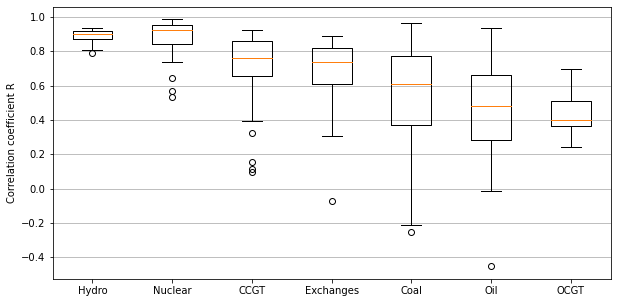

In [40]:
# Distribution of the correlation coefficient calculated for each technology during each week of 2018

corr_coeff_w=pd.DataFrame(columns=list_tech, index=pd.date_range(start=sdate, end=edate, freq='7d'))
for tech in list_tech:
    for date in pd.date_range(start=sdate, end=edate, freq='7d'):
        corr_coeff_w.at[date,tech]=np.corrcoef((MODEL_Dispatch).loc[date:date+datetime.timedelta(days=7),tech], (df_resampled).loc[date:date+datetime.timedelta(days=7),tech])[1][0]

fs=10

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)

axs.boxplot([corr_coeff_w[tech][(corr_coeff_w[tech]>0) | (corr_coeff_w[tech]<0)] for tech in list_tech], labels=labels)
axs.set_ylabel('Correlation coefficient R')
axs.grid(True, axis='y')
fig.savefig('Results\Plot\Weekly R.svg', format='svg')

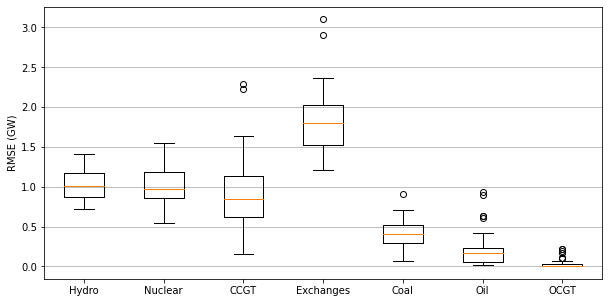

In [41]:
# Distribution of the RMSE calculated for each technology during each week of 2018

RMSE_w=pd.DataFrame(columns=list_tech, index=pd.date_range(start=sdate, end=edate, freq='7d'))
for tech in list_tech:
    for date in pd.date_range(start=sdate, end=edate, freq='7d'):
        RMSE_w.at[date,tech]=RMSE(MODEL_Dispatch.loc[date:date+datetime.timedelta(days=7),tech], df_resampled.loc[date:date+datetime.timedelta(days=7),tech])

fs=10

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)

axs.boxplot([RMSE_w[tech][RMSE_w[tech]>0]/1000 for tech in list_tech], labels=labels)
axs.set_ylabel('RMSE (GW)')
axs.grid(True, axis='y')
fig.savefig('Results\Plot\Weekly RMSE.svg', format='svg')

# 3/ Marginal mix

### a. Models for marginal mix calculation (weekly) 

In [47]:
#JLD: possible to define it at the same time as the commitment model? 
#explain in the titles a bit more the differences
# printing the output only for every start of month?

Weekly hydro-electric powerplants model
   - input: residual consumption (CR)
   - output: ?

In [48]:
def f_hydro2(CR_df,df_hydro, dw):
    CR_mean_hebdo=pd.Series([np.mean(CR_df[list_t_min_12[dw]+datetime.timedelta(minutes=30):list_t_min_12[dw+datetime.timedelta(days=7)]])  for date in pd.date_range(start=list_t_min_12[dw]+datetime.timedelta(minutes=30), end=list_t_min_12[dw+datetime.timedelta(days=7)], freq='30min')], index=pd.date_range(start=list_t_min_12[dw]+datetime.timedelta(minutes=30), end=list_t_min_12[dw+datetime.timedelta(days=7)], freq='30min'), dtype = float)
    CR_mean_12h=pd.Series([np.mean((CR_df-CR_mean_hebdo)[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(hours=12)]]) for i in pd.date_range(start=dw, end=dw+datetime.timedelta(days=6, hours=13), freq='12h') for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], index=[date for i in pd.date_range(start=dw, end=dw+datetime.timedelta(days=6, hours=13), freq='12h') for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], dtype = float)
    CR_st=CR_df[list_t_min_12[dw]+datetime.timedelta(minutes=30):list_t_min_12[dw+datetime.timedelta(days=7)]]-CR_mean_hebdo-CR_mean_12h
    hydro_mean_hebdo=pd.Series([np.mean(df_hydro[list_t_min_12[dw]+datetime.timedelta(minutes=30):list_t_min_12[dw+datetime.timedelta(days=7)]])  for date in pd.date_range(start=list_t_min_12[dw]+datetime.timedelta(minutes=30), end=list_t_min_12[dw+datetime.timedelta(days=7)], freq='30min')], index=pd.date_range(start=list_t_min_12[dw]+datetime.timedelta(minutes=30), end=list_t_min_12[dw+datetime.timedelta(days=7)], freq='30min'), dtype = float)
    hydro_temp=hydro_mean_hebdo+0.19*CR_mean_12h+np.multiply(alpha[list_t_min_12[dw]+datetime.timedelta(minutes=30):list_t_min_12[dw+datetime.timedelta(days=7)]],CR_st)
    corr=pd.Series([np.mean((np.minimum(0,hydro_temp-P_min_hydro))[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(hours=12)]]) for i in pd.date_range(start=dw, end=dw+datetime.timedelta(days=6, hours=13), freq='12h') for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], index=[date for i in pd.date_range(start=dw, end=dw+datetime.timedelta(days=6, hours=13), freq='12h') for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], dtype = float)
    sat=np.minimum(0,hydro_temp-P_min_hydro).loc[hydro_temp.index]
    corr_hebdo=pd.Series([np.mean(sat[list_t_min_12[dw]+datetime.timedelta(minutes=30):list_t_min_12[dw+datetime.timedelta(days=7)]])  for date in pd.date_range(start=list_t_min_12[dw]+datetime.timedelta(minutes=30), end=list_t_min_12[dw+datetime.timedelta(days=7)], freq='30min')], index=pd.date_range(start=list_t_min_12[dw]+datetime.timedelta(minutes=30), end=list_t_min_12[dw+datetime.timedelta(days=7)], freq='30min'), dtype = float)
    corr_w=pd.Series([np.mean((sat)[list_t_min_12[i]+datetime.timedelta(minutes=30):list_t_min_12[i+datetime.timedelta(hours=12)]]) for i in pd.date_range(start=dw, end=dw+datetime.timedelta(days=6, hours=13), freq='12h') for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], index=[date for i in pd.date_range(start=dw, end=dw+datetime.timedelta(days=6, hours=13), freq='12h') for date in pd.date_range(list_t_min_12[i]+datetime.timedelta(minutes=30),list_t_min_12[i+datetime.timedelta(hours=12)],freq='30min')], dtype = float)
    hydro=np.maximum(P_min_hydro,hydro_temp)+((alpha-0.19)/alpha)*corr_w+(0.19/alpha)*corr_hebdo
    return hydro

Weekly model for dispatch (no Scheduling) for the marginal mix calculation for DSM events shorter than one day
   - input: residual consumption (CR)
   - output:

In [49]:
def mod_thermique2(CR,dw):
    Technologies_Dispatch_up_2=MO2
    MODEL_Dispatch1=pd.DataFrame(columns=Technologies_Dispatch_up_2 ,index=pd.date_range(start=list_t_min_date[dw], end =list_t_min_date[dw+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30), freq='30min') , dtype = float)
    Residuel=0
    #Dispatch
    for date in pd.date_range(start=dw, end=dw+datetime.timedelta(days=6)):
        for hour in pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'):
            Residuel=CR[hour]
            List_P_min=P_min.loc[hour,:].values
            List_P_max=P_max.loc[hour,:].values
            for i in range(len(Technologies_Dispatch_up_2)):
                MODEL_Dispatch1.at[hour, Technologies_Dispatch_up_2[i]]=max(min(Residuel-sum(List_P_min[i+1:len(Technologies_Dispatch_up_2)+1]), List_P_max[i]),List_P_min[i])
                Residuel=Residuel-MODEL_Dispatch1.at[hour, Technologies_Dispatch_up_2[i]]
    return MODEL_Dispatch1

Weekly model for dispatch (no Scheduling) for the marginal mix calculation for DSM events shorter than one day
   - input: residual consumption (CR)
   - output:

In [50]:
# JLD: difference with mod_thermique3?
def mod_thermique3(CR,dw):
    Technologies_Dispatch_up_2=MO2
    Technologies_Scheduling2=MO1
    MODEL_Dispatch1=pd.DataFrame(columns=Technologies_Dispatch_up_2 ,index=pd.date_range(start=list_t_min_date[dw]+datetime.timedelta(minutes=30), end =list_t_min_date[dw+datetime.timedelta(days=7)], freq='30min') , dtype = float)
    Residuel=0
    P_min=pd.DataFrame(0,columns=Technologies_Dispatch_up_2, index=MODEL_Dispatch1.index)
    P_min['CCGT_1']=pd.Series(200, index=P_min.index)
    P_max=pd.DataFrame(columns=Technologies_Dispatch_up_2, index=MODEL_Dispatch1.index)
    P_min['Nucleaire - Base']=df_dispo['Nucleaire - Base']
    for i in range (1,n_EP):
        P_min['Ech. p_'+repr(i)] =np.minimum(df_dispo['Ech. p_'+repr(i)],np.maximum(np.zeros(len(df_dispo)),lim_all-P_min.loc[:,['Ech. p_'+repr(j) for j in range(1,i)]].sum(axis=1)))
    #Scheduling
    for date in pd.date_range(start=dw, end=dw+datetime.timedelta(days=6)):
        for i in range(len(Technologies_Scheduling2)):
            P_temp=max(CR[list_t_min_date[date]+datetime.timedelta( minutes=30): list_t_min_date[date+datetime.timedelta( days = 1)]]-P_max.loc[list_t_min_date[date]+datetime.timedelta( minutes=30): list_t_min_date[date+datetime.timedelta( days = 1)],Technologies_Scheduling2[0:i]].sum(axis = 1)-P_min.loc[list_t_min_date[date]+datetime.timedelta( minutes=30): list_t_min_date[date+datetime.timedelta( days = 1)],Technologies_Scheduling2[i+1:len(Technologies_Scheduling2)+1]].sum(axis = 1))           
            for hour in pd.date_range(start=list_t_min_date[date]+datetime.timedelta( minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'):                

                P_max.at[hour,Technologies_Scheduling2[i]]=max(0,P_min.at[hour,Technologies_Scheduling2[i]],min(P_temp,df_dispo.at[hour,Technologies_Scheduling2[i]]))
        P_min.loc[pd.date_range(start=list_t_min_date[date]+datetime.timedelta( minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'),['Ech. p_'+repr(i) for i in range(1,n_EP)]]=pd.DataFrame(0,columns=['Ech. p_'+repr(i) for i in range(1,n_EP)],index=pd.date_range(start=date, end=date+datetime.timedelta(hours = 23, minutes=30), freq='30min'))
        for i in range (n_EP-1,0,-1):
            P_min.loc[list_t_min_date[date]+datetime.timedelta( minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)] ,'Ech. p_'+repr(i)] =np.minimum(P_max.loc[pd.date_range(start=list_t_min_date[date]+datetime.timedelta( minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'),'Ech. p_'+repr(i)],np.maximum(np.zeros(len(P_min['Ech. p_'+repr(i)][list_t_min_date[date]+datetime.timedelta( minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)] ])),lim_all[list_t_min_date[date]+datetime.timedelta( minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)] ]-P_min.loc[pd.date_range(start=list_t_min_date[date]+datetime.timedelta( minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'),['Ech. p_'+repr(j) for j in range(i+1,n_EP)]].sum(axis=1)))
        P_min.loc[list_t_min_date[date]+datetime.timedelta( minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)],'Charbon_1']=np.minimum(300*np.ones(len(P_min['Charbon_1'][list_t_min_date[date]+datetime.timedelta( minutes=30):list_t_min_date[date+datetime.timedelta( days = 1)]])),P_max.loc[pd.date_range(start=list_t_min_date[date]+datetime.timedelta( minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'),'Charbon_1'])
        #Dispatch
        for hour in pd.date_range(start=list_t_min_date[date]+datetime.timedelta(minutes=30), end=list_t_min_date[date+datetime.timedelta( days = 1)], freq='30min'):
            Residuel=CR[hour]
            List_P_min=P_min.loc[hour,:].values
            List_P_max=P_max.loc[hour,:].values
            for i in range(len(Technologies_Dispatch_up_2)):
                MODEL_Dispatch1.at[hour, Technologies_Dispatch_up_2[i]]=max(min(Residuel-sum(List_P_min[i+1:len(Technologies_Dispatch_up_2)+1]), List_P_max[i]),List_P_min[i])
                Residuel=Residuel-MODEL_Dispatch1.at[hour, Technologies_Dispatch_up_2[i]]
    return MODEL_Dispatch1

### b. Results 

Warning: the simulation time is quite long, be patient!

#### Marginal Mix 30 minutes

In [51]:
Flex_30min=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=pd.date_range(start=s_date, end=e_date, freq='30min'))
MixMarg_30min=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=pd.date_range(start=s_date, end=e_date, freq='30min'))
list_res=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC',]+list(df_interco)
for wk in pd.date_range(start=s_date, end=e_date, freq='7d'):
    idx_wk=pd.date_range(start=list_t_min_date[wk]+datetime.timedelta(minutes=30), end =list_t_min_date[wk+datetime.timedelta(days=7)], freq='30min')
    for dte in idx_wk:
        print(dte)
        MODEL_Dispatch_marg=pd.DataFrame(columns=['Hydraulique2', 'Nucleaire', 'Charbon', 'Ech. physiques', 'Gaz - CCGT', 'Gaz - TAC', 'Fioul'], index=idx_wk, dtype = float)
        CR_2=df_resampled.loc[idx_wk,'Dispatchable']+pd.Series([(0)*(d==dte) for d in idx_wk], index=idx_wk)
        MODEL_Dispatch_marg['Hydraulique2']=f_hydro2(df_resampled['Dispatchable']+pd.Series([(-100)*(d==dte) for d in df_resampled.index], index=df_resampled.index),df_resampled['Hydraulique2'],wk)
        MODEL_D=mod_thermique2(df_resampled['Dispatchable']+pd.Series([(-100)*(d==dte) for d in idx_wk], index=idx_wk)-MODEL_Dispatch_marg['Hydraulique2']+df_ntc_export, wk)
        MODEL_Dispatch_marg.loc[:,'Charbon']=MODEL_D['Charbon_1']+MODEL_D['Charbon_2']+MODEL_D['Charbon_3']+MODEL_D['Charbon_4']+MODEL_D['Charbon_5']
        MODEL_Dispatch_marg.loc[:,'Gaz - CCGT']=MODEL_D['CCGT_1']+MODEL_D['CCGT_2']+MODEL_D['CCGT_3']+MODEL_D['CCGT_4']+MODEL_D['CCGT_5']+MODEL_D['CCGT_6']+MODEL_D['CCGT_7']+MODEL_D['CCGT_8']+MODEL_D['CCGT_9']+MODEL_D['CCGT_10']
        MODEL_Dispatch_marg.loc[:,'Nucleaire']=MODEL_D['Nucleaire - Base']+MODEL_D['Nucleaire_1']+MODEL_D['Nucleaire_2']+MODEL_D['Nucleaire_3']+MODEL_D['Nucleaire_4']+MODEL_D['Nucleaire_5']+MODEL_D['Nucleaire_6']
        MODEL_Dispatch_marg.loc[:,'Ech. physiques']=MODEL_D.loc[:,['Ech. p_'+repr(i) for i in range(1,n_EP)]].sum(axis=1)-df_ntc_export
        MODEL_Dispatch_marg.loc[:,'Gaz - TAC']=MODEL_D['Gaz - TAC']
        MODEL_Dispatch_marg.loc[:,'Fioul']=MODEL_D['Fioul - TAC']+MODEL_D['Fioul - Autres']
        mix_marg=MODEL_Dispatch_marg-MODEL_Dispatch
        for country in list(df_interco):
            mix_marg[country]=np.multiply(mix_marg['Ech. physiques'],df_interco[country])
        MixMarg_30min.loc[dte, list_res]=(mix_marg[list_t_min_date[wk]+datetime.timedelta(minutes=30): list_t_min_date[wk+datetime.timedelta(days=7)]]).sum()  
        Flex_30min.loc[dte, :]=mix_marg.loc[dte,:]

2018-01-01 05:30:00
2018-01-01 06:00:00
2018-01-01 06:30:00
2018-01-01 07:00:00
2018-01-01 07:30:00
2018-01-01 08:00:00
2018-01-01 08:30:00
2018-01-01 09:00:00
2018-01-01 09:30:00
2018-01-01 10:00:00
2018-01-01 10:30:00
2018-01-01 11:00:00
2018-01-01 11:30:00
2018-01-01 12:00:00
2018-01-01 12:30:00
2018-01-01 13:00:00
2018-01-01 13:30:00
2018-01-01 14:00:00
2018-01-01 14:30:00
2018-01-01 15:00:00
2018-01-01 15:30:00
2018-01-01 16:00:00
2018-01-01 16:30:00
2018-01-01 17:00:00
2018-01-01 17:30:00
2018-01-01 18:00:00
2018-01-01 18:30:00
2018-01-01 19:00:00
2018-01-01 19:30:00
2018-01-01 20:00:00
2018-01-01 20:30:00
2018-01-01 21:00:00
2018-01-01 21:30:00
2018-01-01 22:00:00
2018-01-01 22:30:00
2018-01-01 23:00:00
2018-01-01 23:30:00
2018-01-02 00:00:00
2018-01-02 00:30:00
2018-01-02 01:00:00
2018-01-02 01:30:00
2018-01-02 02:00:00
2018-01-02 02:30:00
2018-01-02 03:00:00
2018-01-02 03:30:00
2018-01-02 04:00:00
2018-01-02 04:30:00
2018-01-02 05:00:00
2018-01-02 05:30:00
2018-01-02 06:00:00


2018-01-09 18:30:00
2018-01-09 19:00:00
2018-01-09 19:30:00
2018-01-09 20:00:00
2018-01-09 20:30:00
2018-01-09 21:00:00
2018-01-09 21:30:00
2018-01-09 22:00:00
2018-01-09 22:30:00
2018-01-09 23:00:00
2018-01-09 23:30:00
2018-01-10 00:00:00
2018-01-10 00:30:00
2018-01-10 01:00:00
2018-01-10 01:30:00
2018-01-10 02:00:00
2018-01-10 02:30:00
2018-01-10 03:00:00
2018-01-10 03:30:00
2018-01-10 04:00:00
2018-01-10 04:30:00
2018-01-10 05:00:00
2018-01-10 05:30:00
2018-01-10 06:00:00
2018-01-10 06:30:00
2018-01-10 07:00:00
2018-01-10 07:30:00
2018-01-10 08:00:00
2018-01-10 08:30:00
2018-01-10 09:00:00
2018-01-10 09:30:00
2018-01-10 10:00:00
2018-01-10 10:30:00
2018-01-10 11:00:00
2018-01-10 11:30:00
2018-01-10 12:00:00
2018-01-10 12:30:00
2018-01-10 13:00:00
2018-01-10 13:30:00
2018-01-10 14:00:00
2018-01-10 14:30:00
2018-01-10 15:00:00
2018-01-10 15:30:00
2018-01-10 16:00:00
2018-01-10 16:30:00
2018-01-10 17:00:00
2018-01-10 17:30:00
2018-01-10 18:00:00
2018-01-10 18:30:00
2018-01-10 19:00:00


2018-01-18 07:30:00
2018-01-18 08:00:00
2018-01-18 08:30:00
2018-01-18 09:00:00
2018-01-18 09:30:00
2018-01-18 10:00:00
2018-01-18 10:30:00
2018-01-18 11:00:00
2018-01-18 11:30:00
2018-01-18 12:00:00
2018-01-18 12:30:00
2018-01-18 13:00:00
2018-01-18 13:30:00
2018-01-18 14:00:00
2018-01-18 14:30:00
2018-01-18 15:00:00
2018-01-18 15:30:00
2018-01-18 16:00:00
2018-01-18 16:30:00
2018-01-18 17:00:00
2018-01-18 17:30:00
2018-01-18 18:00:00
2018-01-18 18:30:00
2018-01-18 19:00:00
2018-01-18 19:30:00
2018-01-18 20:00:00
2018-01-18 20:30:00
2018-01-18 21:00:00
2018-01-18 21:30:00
2018-01-18 22:00:00
2018-01-18 22:30:00
2018-01-18 23:00:00
2018-01-18 23:30:00
2018-01-19 00:00:00
2018-01-19 00:30:00
2018-01-19 01:00:00
2018-01-19 01:30:00
2018-01-19 02:00:00
2018-01-19 02:30:00
2018-01-19 03:00:00
2018-01-19 03:30:00
2018-01-19 04:00:00
2018-01-19 04:30:00
2018-01-19 05:00:00
2018-01-19 05:30:00
2018-01-19 06:00:00
2018-01-19 06:30:00
2018-01-19 07:00:00
2018-01-19 07:30:00
2018-01-19 08:00:00


2018-01-26 20:30:00
2018-01-26 21:00:00
2018-01-26 21:30:00
2018-01-26 22:00:00
2018-01-26 22:30:00
2018-01-26 23:00:00
2018-01-26 23:30:00
2018-01-27 00:00:00
2018-01-27 00:30:00
2018-01-27 01:00:00
2018-01-27 01:30:00
2018-01-27 02:00:00
2018-01-27 02:30:00
2018-01-27 03:00:00
2018-01-27 03:30:00
2018-01-27 04:00:00
2018-01-27 04:30:00
2018-01-27 05:00:00
2018-01-27 05:30:00
2018-01-27 06:00:00
2018-01-27 06:30:00
2018-01-27 07:00:00
2018-01-27 07:30:00
2018-01-27 08:00:00
2018-01-27 08:30:00
2018-01-27 09:00:00
2018-01-27 09:30:00
2018-01-27 10:00:00
2018-01-27 10:30:00
2018-01-27 11:00:00
2018-01-27 11:30:00
2018-01-27 12:00:00
2018-01-27 12:30:00
2018-01-27 13:00:00
2018-01-27 13:30:00
2018-01-27 14:00:00
2018-01-27 14:30:00
2018-01-27 15:00:00
2018-01-27 15:30:00
2018-01-27 16:00:00
2018-01-27 16:30:00
2018-01-27 17:00:00
2018-01-27 17:30:00
2018-01-27 18:00:00
2018-01-27 18:30:00
2018-01-27 19:00:00
2018-01-27 19:30:00
2018-01-27 20:00:00
2018-01-27 20:30:00
2018-01-27 21:00:00


2018-02-04 09:30:00
2018-02-04 10:00:00
2018-02-04 10:30:00
2018-02-04 11:00:00
2018-02-04 11:30:00
2018-02-04 12:00:00
2018-02-04 12:30:00
2018-02-04 13:00:00
2018-02-04 13:30:00
2018-02-04 14:00:00
2018-02-04 14:30:00
2018-02-04 15:00:00
2018-02-04 15:30:00
2018-02-04 16:00:00
2018-02-04 16:30:00
2018-02-04 17:00:00
2018-02-04 17:30:00
2018-02-04 18:00:00
2018-02-04 18:30:00
2018-02-04 19:00:00
2018-02-04 19:30:00
2018-02-04 20:00:00
2018-02-04 20:30:00
2018-02-04 21:00:00
2018-02-04 21:30:00
2018-02-04 22:00:00
2018-02-04 22:30:00
2018-02-04 23:00:00
2018-02-04 23:30:00
2018-02-05 00:00:00
2018-02-05 00:30:00
2018-02-05 01:00:00
2018-02-05 01:30:00
2018-02-05 02:00:00
2018-02-05 02:30:00
2018-02-05 03:00:00
2018-02-05 03:30:00
2018-02-05 04:00:00
2018-02-05 04:30:00
2018-02-05 05:00:00
2018-02-05 05:30:00
2018-02-05 06:00:00
2018-02-05 06:30:00
2018-02-05 07:00:00
2018-02-05 07:30:00
2018-02-05 08:00:00
2018-02-05 08:30:00
2018-02-05 09:00:00
2018-02-05 09:30:00
2018-02-05 10:00:00


2018-02-12 22:30:00
2018-02-12 23:00:00
2018-02-12 23:30:00
2018-02-13 00:00:00
2018-02-13 00:30:00
2018-02-13 01:00:00
2018-02-13 01:30:00
2018-02-13 02:00:00
2018-02-13 02:30:00
2018-02-13 03:00:00
2018-02-13 03:30:00
2018-02-13 04:00:00
2018-02-13 04:30:00
2018-02-13 05:00:00
2018-02-13 05:30:00
2018-02-13 06:00:00
2018-02-13 06:30:00
2018-02-13 07:00:00
2018-02-13 07:30:00
2018-02-13 08:00:00
2018-02-13 08:30:00
2018-02-13 09:00:00
2018-02-13 09:30:00
2018-02-13 10:00:00
2018-02-13 10:30:00
2018-02-13 11:00:00
2018-02-13 11:30:00
2018-02-13 12:00:00
2018-02-13 12:30:00
2018-02-13 13:00:00
2018-02-13 13:30:00
2018-02-13 14:00:00
2018-02-13 14:30:00
2018-02-13 15:00:00
2018-02-13 15:30:00
2018-02-13 16:00:00
2018-02-13 16:30:00
2018-02-13 17:00:00
2018-02-13 17:30:00
2018-02-13 18:00:00
2018-02-13 18:30:00
2018-02-13 19:00:00
2018-02-13 19:30:00
2018-02-13 20:00:00
2018-02-13 20:30:00
2018-02-13 21:00:00
2018-02-13 21:30:00
2018-02-13 22:00:00
2018-02-13 22:30:00
2018-02-13 23:00:00


2018-02-21 11:30:00
2018-02-21 12:00:00
2018-02-21 12:30:00
2018-02-21 13:00:00
2018-02-21 13:30:00
2018-02-21 14:00:00
2018-02-21 14:30:00
2018-02-21 15:00:00
2018-02-21 15:30:00
2018-02-21 16:00:00
2018-02-21 16:30:00
2018-02-21 17:00:00
2018-02-21 17:30:00
2018-02-21 18:00:00
2018-02-21 18:30:00
2018-02-21 19:00:00
2018-02-21 19:30:00
2018-02-21 20:00:00
2018-02-21 20:30:00
2018-02-21 21:00:00
2018-02-21 21:30:00
2018-02-21 22:00:00
2018-02-21 22:30:00
2018-02-21 23:00:00
2018-02-21 23:30:00
2018-02-22 00:00:00
2018-02-22 00:30:00
2018-02-22 01:00:00
2018-02-22 01:30:00
2018-02-22 02:00:00
2018-02-22 02:30:00
2018-02-22 03:00:00
2018-02-22 03:30:00
2018-02-22 04:00:00
2018-02-22 04:30:00
2018-02-22 05:00:00
2018-02-22 05:30:00
2018-02-22 06:00:00
2018-02-22 06:30:00
2018-02-22 07:00:00
2018-02-22 07:30:00
2018-02-22 08:00:00
2018-02-22 08:30:00
2018-02-22 09:00:00
2018-02-22 09:30:00
2018-02-22 10:00:00
2018-02-22 10:30:00
2018-02-22 11:00:00
2018-02-22 11:30:00
2018-02-22 12:00:00


2018-03-02 00:30:00
2018-03-02 01:00:00
2018-03-02 01:30:00
2018-03-02 02:00:00
2018-03-02 02:30:00
2018-03-02 03:00:00
2018-03-02 03:30:00
2018-03-02 04:00:00
2018-03-02 04:30:00
2018-03-02 05:00:00
2018-03-02 05:30:00
2018-03-02 06:00:00
2018-03-02 06:30:00
2018-03-02 07:00:00
2018-03-02 07:30:00
2018-03-02 08:00:00
2018-03-02 08:30:00
2018-03-02 09:00:00
2018-03-02 09:30:00
2018-03-02 10:00:00
2018-03-02 10:30:00
2018-03-02 11:00:00
2018-03-02 11:30:00
2018-03-02 12:00:00
2018-03-02 12:30:00
2018-03-02 13:00:00
2018-03-02 13:30:00
2018-03-02 14:00:00
2018-03-02 14:30:00
2018-03-02 15:00:00
2018-03-02 15:30:00
2018-03-02 16:00:00
2018-03-02 16:30:00
2018-03-02 17:00:00
2018-03-02 17:30:00
2018-03-02 18:00:00
2018-03-02 18:30:00
2018-03-02 19:00:00
2018-03-02 19:30:00
2018-03-02 20:00:00
2018-03-02 20:30:00
2018-03-02 21:00:00
2018-03-02 21:30:00
2018-03-02 22:00:00
2018-03-02 22:30:00
2018-03-02 23:00:00
2018-03-02 23:30:00
2018-03-03 00:00:00
2018-03-03 00:30:00
2018-03-03 01:00:00


2018-03-10 13:30:00
2018-03-10 14:00:00
2018-03-10 14:30:00
2018-03-10 15:00:00
2018-03-10 15:30:00
2018-03-10 16:00:00
2018-03-10 16:30:00
2018-03-10 17:00:00
2018-03-10 17:30:00
2018-03-10 18:00:00
2018-03-10 18:30:00
2018-03-10 19:00:00
2018-03-10 19:30:00
2018-03-10 20:00:00
2018-03-10 20:30:00
2018-03-10 21:00:00
2018-03-10 21:30:00
2018-03-10 22:00:00
2018-03-10 22:30:00
2018-03-10 23:00:00
2018-03-10 23:30:00
2018-03-11 00:00:00
2018-03-11 00:30:00
2018-03-11 01:00:00
2018-03-11 01:30:00
2018-03-11 02:00:00
2018-03-11 02:30:00
2018-03-11 03:00:00
2018-03-11 03:30:00
2018-03-11 04:00:00
2018-03-11 04:30:00
2018-03-11 05:00:00
2018-03-11 05:30:00
2018-03-11 06:00:00
2018-03-11 06:30:00
2018-03-11 07:00:00
2018-03-11 07:30:00
2018-03-11 08:00:00
2018-03-11 08:30:00
2018-03-11 09:00:00
2018-03-11 09:30:00
2018-03-11 10:00:00
2018-03-11 10:30:00
2018-03-11 11:00:00
2018-03-11 11:30:00
2018-03-11 12:00:00
2018-03-11 12:30:00
2018-03-11 13:00:00
2018-03-11 13:30:00
2018-03-11 14:00:00


2018-03-19 02:30:00
2018-03-19 03:00:00
2018-03-19 03:30:00
2018-03-19 04:00:00
2018-03-19 04:30:00
2018-03-19 05:00:00
2018-03-19 05:30:00
2018-03-19 06:00:00
2018-03-19 06:30:00
2018-03-19 07:00:00
2018-03-19 07:30:00
2018-03-19 08:00:00
2018-03-19 08:30:00
2018-03-19 09:00:00
2018-03-19 09:30:00
2018-03-19 10:00:00
2018-03-19 10:30:00
2018-03-19 11:00:00
2018-03-19 11:30:00
2018-03-19 12:00:00
2018-03-19 12:30:00
2018-03-19 13:00:00
2018-03-19 13:30:00
2018-03-19 14:00:00
2018-03-19 14:30:00
2018-03-19 15:00:00
2018-03-19 15:30:00
2018-03-19 16:00:00
2018-03-19 16:30:00
2018-03-19 17:00:00
2018-03-19 17:30:00
2018-03-19 18:00:00
2018-03-19 18:30:00
2018-03-19 19:00:00
2018-03-19 19:30:00
2018-03-19 20:00:00
2018-03-19 20:30:00
2018-03-19 21:00:00
2018-03-19 21:30:00
2018-03-19 22:00:00
2018-03-19 22:30:00
2018-03-19 23:00:00
2018-03-19 23:30:00
2018-03-20 00:00:00
2018-03-20 00:30:00
2018-03-20 01:00:00
2018-03-20 01:30:00
2018-03-20 02:00:00
2018-03-20 02:30:00
2018-03-20 03:00:00


2018-03-27 15:30:00
2018-03-27 16:00:00
2018-03-27 16:30:00
2018-03-27 17:00:00
2018-03-27 17:30:00
2018-03-27 18:00:00
2018-03-27 18:30:00
2018-03-27 19:00:00
2018-03-27 19:30:00
2018-03-27 20:00:00
2018-03-27 20:30:00
2018-03-27 21:00:00
2018-03-27 21:30:00
2018-03-27 22:00:00
2018-03-27 22:30:00
2018-03-27 23:00:00
2018-03-27 23:30:00
2018-03-28 00:00:00
2018-03-28 00:30:00
2018-03-28 01:00:00
2018-03-28 01:30:00
2018-03-28 02:00:00
2018-03-28 02:30:00
2018-03-28 03:00:00
2018-03-28 03:30:00
2018-03-28 04:00:00
2018-03-28 04:30:00
2018-03-28 05:00:00
2018-03-28 05:30:00
2018-03-28 06:00:00
2018-03-28 06:30:00
2018-03-28 07:00:00
2018-03-28 07:30:00
2018-03-28 08:00:00
2018-03-28 08:30:00
2018-03-28 09:00:00
2018-03-28 09:30:00
2018-03-28 10:00:00
2018-03-28 10:30:00
2018-03-28 11:00:00
2018-03-28 11:30:00
2018-03-28 12:00:00
2018-03-28 12:30:00
2018-03-28 13:00:00
2018-03-28 13:30:00
2018-03-28 14:00:00
2018-03-28 14:30:00
2018-03-28 15:00:00
2018-03-28 15:30:00
2018-03-28 16:00:00


2018-04-05 04:30:00
2018-04-05 05:00:00
2018-04-05 05:30:00
2018-04-05 06:00:00
2018-04-05 06:30:00
2018-04-05 07:00:00
2018-04-05 07:30:00
2018-04-05 08:00:00
2018-04-05 08:30:00
2018-04-05 09:00:00
2018-04-05 09:30:00
2018-04-05 10:00:00
2018-04-05 10:30:00
2018-04-05 11:00:00
2018-04-05 11:30:00
2018-04-05 12:00:00
2018-04-05 12:30:00
2018-04-05 13:00:00
2018-04-05 13:30:00
2018-04-05 14:00:00
2018-04-05 14:30:00
2018-04-05 15:00:00
2018-04-05 15:30:00
2018-04-05 16:00:00
2018-04-05 16:30:00
2018-04-05 17:00:00
2018-04-05 17:30:00
2018-04-05 18:00:00
2018-04-05 18:30:00
2018-04-05 19:00:00
2018-04-05 19:30:00
2018-04-05 20:00:00
2018-04-05 20:30:00
2018-04-05 21:00:00
2018-04-05 21:30:00
2018-04-05 22:00:00
2018-04-05 22:30:00
2018-04-05 23:00:00
2018-04-05 23:30:00
2018-04-06 00:00:00
2018-04-06 00:30:00
2018-04-06 01:00:00
2018-04-06 01:30:00
2018-04-06 02:00:00
2018-04-06 02:30:00
2018-04-06 03:00:00
2018-04-06 03:30:00
2018-04-06 04:00:00
2018-04-06 04:30:00
2018-04-06 05:00:00


2018-04-13 17:30:00
2018-04-13 18:00:00
2018-04-13 18:30:00
2018-04-13 19:00:00
2018-04-13 19:30:00
2018-04-13 20:00:00
2018-04-13 20:30:00
2018-04-13 21:00:00
2018-04-13 21:30:00
2018-04-13 22:00:00
2018-04-13 22:30:00
2018-04-13 23:00:00
2018-04-13 23:30:00
2018-04-14 00:00:00
2018-04-14 00:30:00
2018-04-14 01:00:00
2018-04-14 01:30:00
2018-04-14 02:00:00
2018-04-14 02:30:00
2018-04-14 03:00:00
2018-04-14 03:30:00
2018-04-14 04:00:00
2018-04-14 04:30:00
2018-04-14 05:00:00
2018-04-14 05:30:00
2018-04-14 06:00:00
2018-04-14 06:30:00
2018-04-14 07:00:00
2018-04-14 07:30:00
2018-04-14 08:00:00
2018-04-14 08:30:00
2018-04-14 09:00:00
2018-04-14 09:30:00
2018-04-14 10:00:00
2018-04-14 10:30:00
2018-04-14 11:00:00
2018-04-14 11:30:00
2018-04-14 12:00:00
2018-04-14 12:30:00
2018-04-14 13:00:00
2018-04-14 13:30:00
2018-04-14 14:00:00
2018-04-14 14:30:00
2018-04-14 15:00:00
2018-04-14 15:30:00
2018-04-14 16:00:00
2018-04-14 16:30:00
2018-04-14 17:00:00
2018-04-14 17:30:00
2018-04-14 18:00:00


2018-04-22 06:30:00
2018-04-22 07:00:00
2018-04-22 07:30:00
2018-04-22 08:00:00
2018-04-22 08:30:00
2018-04-22 09:00:00
2018-04-22 09:30:00
2018-04-22 10:00:00
2018-04-22 10:30:00
2018-04-22 11:00:00
2018-04-22 11:30:00
2018-04-22 12:00:00
2018-04-22 12:30:00
2018-04-22 13:00:00
2018-04-22 13:30:00
2018-04-22 14:00:00
2018-04-22 14:30:00
2018-04-22 15:00:00
2018-04-22 15:30:00
2018-04-22 16:00:00
2018-04-22 16:30:00
2018-04-22 17:00:00
2018-04-22 17:30:00
2018-04-22 18:00:00
2018-04-22 18:30:00
2018-04-22 19:00:00
2018-04-22 19:30:00
2018-04-22 20:00:00
2018-04-22 20:30:00
2018-04-22 21:00:00
2018-04-22 21:30:00
2018-04-22 22:00:00
2018-04-22 22:30:00
2018-04-22 23:00:00
2018-04-22 23:30:00
2018-04-23 00:00:00
2018-04-23 00:30:00
2018-04-23 01:00:00
2018-04-23 01:30:00
2018-04-23 02:00:00
2018-04-23 02:30:00
2018-04-23 03:00:00
2018-04-23 03:30:00
2018-04-23 04:00:00
2018-04-23 04:30:00
2018-04-23 05:00:00
2018-04-23 05:30:00
2018-04-23 06:00:00
2018-04-23 06:30:00
2018-04-23 07:00:00


2018-04-30 19:30:00
2018-04-30 20:00:00
2018-04-30 20:30:00
2018-04-30 21:00:00
2018-04-30 21:30:00
2018-04-30 22:00:00
2018-04-30 22:30:00
2018-04-30 23:00:00
2018-04-30 23:30:00
2018-05-01 00:00:00
2018-05-01 00:30:00
2018-05-01 01:00:00
2018-05-01 01:30:00
2018-05-01 02:00:00
2018-05-01 02:30:00
2018-05-01 03:00:00
2018-05-01 03:30:00
2018-05-01 04:00:00
2018-05-01 04:30:00
2018-05-01 05:00:00
2018-05-01 05:30:00
2018-05-01 06:00:00
2018-05-01 06:30:00
2018-05-01 07:00:00
2018-05-01 07:30:00
2018-05-01 08:00:00
2018-05-01 08:30:00
2018-05-01 09:00:00
2018-05-01 09:30:00
2018-05-01 10:00:00
2018-05-01 10:30:00
2018-05-01 11:00:00
2018-05-01 11:30:00
2018-05-01 12:00:00
2018-05-01 12:30:00
2018-05-01 13:00:00
2018-05-01 13:30:00
2018-05-01 14:00:00
2018-05-01 14:30:00
2018-05-01 15:00:00
2018-05-01 15:30:00
2018-05-01 16:00:00
2018-05-01 16:30:00
2018-05-01 17:00:00
2018-05-01 17:30:00
2018-05-01 18:00:00
2018-05-01 18:30:00
2018-05-01 19:00:00
2018-05-01 19:30:00
2018-05-01 20:00:00


2018-05-09 08:30:00
2018-05-09 09:00:00
2018-05-09 09:30:00
2018-05-09 10:00:00
2018-05-09 10:30:00
2018-05-09 11:00:00
2018-05-09 11:30:00
2018-05-09 12:00:00
2018-05-09 12:30:00
2018-05-09 13:00:00
2018-05-09 13:30:00
2018-05-09 14:00:00
2018-05-09 14:30:00
2018-05-09 15:00:00
2018-05-09 15:30:00
2018-05-09 16:00:00
2018-05-09 16:30:00
2018-05-09 17:00:00
2018-05-09 17:30:00
2018-05-09 18:00:00
2018-05-09 18:30:00
2018-05-09 19:00:00
2018-05-09 19:30:00
2018-05-09 20:00:00
2018-05-09 20:30:00
2018-05-09 21:00:00
2018-05-09 21:30:00
2018-05-09 22:00:00
2018-05-09 22:30:00
2018-05-09 23:00:00
2018-05-09 23:30:00
2018-05-10 00:00:00
2018-05-10 00:30:00
2018-05-10 01:00:00
2018-05-10 01:30:00
2018-05-10 02:00:00
2018-05-10 02:30:00
2018-05-10 03:00:00
2018-05-10 03:30:00
2018-05-10 04:00:00
2018-05-10 04:30:00
2018-05-10 05:00:00
2018-05-10 05:30:00
2018-05-10 06:00:00
2018-05-10 06:30:00
2018-05-10 07:00:00
2018-05-10 07:30:00
2018-05-10 08:00:00
2018-05-10 08:30:00
2018-05-10 09:00:00


2018-05-17 21:30:00
2018-05-17 22:00:00
2018-05-17 22:30:00
2018-05-17 23:00:00
2018-05-17 23:30:00
2018-05-18 00:00:00
2018-05-18 00:30:00
2018-05-18 01:00:00
2018-05-18 01:30:00
2018-05-18 02:00:00
2018-05-18 02:30:00
2018-05-18 03:00:00
2018-05-18 03:30:00
2018-05-18 04:00:00
2018-05-18 04:30:00
2018-05-18 05:00:00
2018-05-18 05:30:00
2018-05-18 06:00:00
2018-05-18 06:30:00
2018-05-18 07:00:00
2018-05-18 07:30:00
2018-05-18 08:00:00
2018-05-18 08:30:00
2018-05-18 09:00:00
2018-05-18 09:30:00
2018-05-18 10:00:00
2018-05-18 10:30:00
2018-05-18 11:00:00
2018-05-18 11:30:00
2018-05-18 12:00:00
2018-05-18 12:30:00
2018-05-18 13:00:00
2018-05-18 13:30:00
2018-05-18 14:00:00
2018-05-18 14:30:00
2018-05-18 15:00:00
2018-05-18 15:30:00
2018-05-18 16:00:00
2018-05-18 16:30:00
2018-05-18 17:00:00
2018-05-18 17:30:00
2018-05-18 18:00:00
2018-05-18 18:30:00
2018-05-18 19:00:00
2018-05-18 19:30:00
2018-05-18 20:00:00
2018-05-18 20:30:00
2018-05-18 21:00:00
2018-05-18 21:30:00
2018-05-18 22:00:00


2018-05-26 10:30:00
2018-05-26 11:00:00
2018-05-26 11:30:00
2018-05-26 12:00:00
2018-05-26 12:30:00
2018-05-26 13:00:00
2018-05-26 13:30:00
2018-05-26 14:00:00
2018-05-26 14:30:00
2018-05-26 15:00:00
2018-05-26 15:30:00
2018-05-26 16:00:00
2018-05-26 16:30:00
2018-05-26 17:00:00
2018-05-26 17:30:00
2018-05-26 18:00:00
2018-05-26 18:30:00
2018-05-26 19:00:00
2018-05-26 19:30:00
2018-05-26 20:00:00
2018-05-26 20:30:00
2018-05-26 21:00:00
2018-05-26 21:30:00
2018-05-26 22:00:00
2018-05-26 22:30:00
2018-05-26 23:00:00
2018-05-26 23:30:00
2018-05-27 00:00:00
2018-05-27 00:30:00
2018-05-27 01:00:00
2018-05-27 01:30:00
2018-05-27 02:00:00
2018-05-27 02:30:00
2018-05-27 03:00:00
2018-05-27 03:30:00
2018-05-27 04:00:00
2018-05-27 04:30:00
2018-05-27 05:00:00
2018-05-27 05:30:00
2018-05-27 06:00:00
2018-05-27 06:30:00
2018-05-27 07:00:00
2018-05-27 07:30:00
2018-05-27 08:00:00
2018-05-27 08:30:00
2018-05-27 09:00:00
2018-05-27 09:30:00
2018-05-27 10:00:00
2018-05-27 10:30:00
2018-05-27 11:00:00


2018-06-03 23:30:00
2018-06-04 00:00:00
2018-06-04 00:30:00
2018-06-04 01:00:00
2018-06-04 01:30:00
2018-06-04 02:00:00
2018-06-04 02:30:00
2018-06-04 03:00:00
2018-06-04 03:30:00
2018-06-04 04:00:00
2018-06-04 04:30:00
2018-06-04 05:00:00
2018-06-04 05:30:00
2018-06-04 06:00:00
2018-06-04 06:30:00
2018-06-04 07:00:00
2018-06-04 07:30:00
2018-06-04 08:00:00
2018-06-04 08:30:00
2018-06-04 09:00:00
2018-06-04 09:30:00
2018-06-04 10:00:00
2018-06-04 10:30:00
2018-06-04 11:00:00
2018-06-04 11:30:00
2018-06-04 12:00:00
2018-06-04 12:30:00
2018-06-04 13:00:00
2018-06-04 13:30:00
2018-06-04 14:00:00
2018-06-04 14:30:00
2018-06-04 15:00:00
2018-06-04 15:30:00
2018-06-04 16:00:00
2018-06-04 16:30:00
2018-06-04 17:00:00
2018-06-04 17:30:00
2018-06-04 18:00:00
2018-06-04 18:30:00
2018-06-04 19:00:00
2018-06-04 19:30:00
2018-06-04 20:00:00
2018-06-04 20:30:00
2018-06-04 21:00:00
2018-06-04 21:30:00
2018-06-04 22:00:00
2018-06-04 22:30:00
2018-06-04 23:00:00
2018-06-04 23:30:00
2018-06-05 00:00:00


2018-06-12 12:30:00
2018-06-12 13:00:00
2018-06-12 13:30:00
2018-06-12 14:00:00
2018-06-12 14:30:00
2018-06-12 15:00:00
2018-06-12 15:30:00
2018-06-12 16:00:00
2018-06-12 16:30:00
2018-06-12 17:00:00
2018-06-12 17:30:00
2018-06-12 18:00:00
2018-06-12 18:30:00
2018-06-12 19:00:00
2018-06-12 19:30:00
2018-06-12 20:00:00
2018-06-12 20:30:00
2018-06-12 21:00:00
2018-06-12 21:30:00
2018-06-12 22:00:00
2018-06-12 22:30:00
2018-06-12 23:00:00
2018-06-12 23:30:00
2018-06-13 00:00:00
2018-06-13 00:30:00
2018-06-13 01:00:00
2018-06-13 01:30:00
2018-06-13 02:00:00
2018-06-13 02:30:00
2018-06-13 03:00:00
2018-06-13 03:30:00
2018-06-13 04:00:00
2018-06-13 04:30:00
2018-06-13 05:00:00
2018-06-13 05:30:00
2018-06-13 06:00:00
2018-06-13 06:30:00
2018-06-13 07:00:00
2018-06-13 07:30:00
2018-06-13 08:00:00
2018-06-13 08:30:00
2018-06-13 09:00:00
2018-06-13 09:30:00
2018-06-13 10:00:00
2018-06-13 10:30:00
2018-06-13 11:00:00
2018-06-13 11:30:00
2018-06-13 12:00:00
2018-06-13 12:30:00
2018-06-13 13:00:00


2018-06-21 01:30:00
2018-06-21 02:00:00
2018-06-21 02:30:00
2018-06-21 03:00:00
2018-06-21 03:30:00
2018-06-21 04:00:00
2018-06-21 04:30:00
2018-06-21 05:00:00
2018-06-21 05:30:00
2018-06-21 06:00:00
2018-06-21 06:30:00
2018-06-21 07:00:00
2018-06-21 07:30:00
2018-06-21 08:00:00
2018-06-21 08:30:00
2018-06-21 09:00:00
2018-06-21 09:30:00
2018-06-21 10:00:00
2018-06-21 10:30:00
2018-06-21 11:00:00
2018-06-21 11:30:00
2018-06-21 12:00:00
2018-06-21 12:30:00
2018-06-21 13:00:00
2018-06-21 13:30:00
2018-06-21 14:00:00
2018-06-21 14:30:00
2018-06-21 15:00:00
2018-06-21 15:30:00
2018-06-21 16:00:00
2018-06-21 16:30:00
2018-06-21 17:00:00
2018-06-21 17:30:00
2018-06-21 18:00:00
2018-06-21 18:30:00
2018-06-21 19:00:00
2018-06-21 19:30:00
2018-06-21 20:00:00
2018-06-21 20:30:00
2018-06-21 21:00:00
2018-06-21 21:30:00
2018-06-21 22:00:00
2018-06-21 22:30:00
2018-06-21 23:00:00
2018-06-21 23:30:00
2018-06-22 00:00:00
2018-06-22 00:30:00
2018-06-22 01:00:00
2018-06-22 01:30:00
2018-06-22 02:00:00


2018-06-29 14:30:00
2018-06-29 15:00:00
2018-06-29 15:30:00
2018-06-29 16:00:00
2018-06-29 16:30:00
2018-06-29 17:00:00
2018-06-29 17:30:00
2018-06-29 18:00:00
2018-06-29 18:30:00
2018-06-29 19:00:00
2018-06-29 19:30:00
2018-06-29 20:00:00
2018-06-29 20:30:00
2018-06-29 21:00:00
2018-06-29 21:30:00
2018-06-29 22:00:00
2018-06-29 22:30:00
2018-06-29 23:00:00
2018-06-29 23:30:00
2018-06-30 00:00:00
2018-06-30 00:30:00
2018-06-30 01:00:00
2018-06-30 01:30:00
2018-06-30 02:00:00
2018-06-30 02:30:00
2018-06-30 03:00:00
2018-06-30 03:30:00
2018-06-30 04:00:00
2018-06-30 04:30:00
2018-06-30 05:00:00
2018-06-30 05:30:00
2018-06-30 06:00:00
2018-06-30 06:30:00
2018-06-30 07:00:00
2018-06-30 07:30:00
2018-06-30 08:00:00
2018-06-30 08:30:00
2018-06-30 09:00:00
2018-06-30 09:30:00
2018-06-30 10:00:00
2018-06-30 10:30:00
2018-06-30 11:00:00
2018-06-30 11:30:00
2018-06-30 12:00:00
2018-06-30 12:30:00
2018-06-30 13:00:00
2018-06-30 13:30:00
2018-06-30 14:00:00
2018-06-30 14:30:00
2018-06-30 15:00:00


2018-07-08 03:30:00
2018-07-08 04:00:00
2018-07-08 04:30:00
2018-07-08 05:00:00
2018-07-08 05:30:00
2018-07-08 06:00:00
2018-07-08 06:30:00
2018-07-08 07:00:00
2018-07-08 07:30:00
2018-07-08 08:00:00
2018-07-08 08:30:00
2018-07-08 09:00:00
2018-07-08 09:30:00
2018-07-08 10:00:00
2018-07-08 10:30:00
2018-07-08 11:00:00
2018-07-08 11:30:00
2018-07-08 12:00:00
2018-07-08 12:30:00
2018-07-08 13:00:00
2018-07-08 13:30:00
2018-07-08 14:00:00
2018-07-08 14:30:00
2018-07-08 15:00:00
2018-07-08 15:30:00
2018-07-08 16:00:00
2018-07-08 16:30:00
2018-07-08 17:00:00
2018-07-08 17:30:00
2018-07-08 18:00:00
2018-07-08 18:30:00
2018-07-08 19:00:00
2018-07-08 19:30:00
2018-07-08 20:00:00
2018-07-08 20:30:00
2018-07-08 21:00:00
2018-07-08 21:30:00
2018-07-08 22:00:00
2018-07-08 22:30:00
2018-07-08 23:00:00
2018-07-08 23:30:00
2018-07-09 00:00:00
2018-07-09 00:30:00
2018-07-09 01:00:00
2018-07-09 01:30:00
2018-07-09 02:00:00
2018-07-09 02:30:00
2018-07-09 03:00:00
2018-07-09 03:30:00
2018-07-09 04:00:00


2018-07-16 16:30:00
2018-07-16 17:00:00
2018-07-16 17:30:00
2018-07-16 18:00:00
2018-07-16 18:30:00
2018-07-16 19:00:00
2018-07-16 19:30:00
2018-07-16 20:00:00
2018-07-16 20:30:00
2018-07-16 21:00:00
2018-07-16 21:30:00
2018-07-16 22:00:00
2018-07-16 22:30:00
2018-07-16 23:00:00
2018-07-16 23:30:00
2018-07-17 00:00:00
2018-07-17 00:30:00
2018-07-17 01:00:00
2018-07-17 01:30:00
2018-07-17 02:00:00
2018-07-17 02:30:00
2018-07-17 03:00:00
2018-07-17 03:30:00
2018-07-17 04:00:00
2018-07-17 04:30:00
2018-07-17 05:00:00
2018-07-17 05:30:00
2018-07-17 06:00:00
2018-07-17 06:30:00
2018-07-17 07:00:00
2018-07-17 07:30:00
2018-07-17 08:00:00
2018-07-17 08:30:00
2018-07-17 09:00:00
2018-07-17 09:30:00
2018-07-17 10:00:00
2018-07-17 10:30:00
2018-07-17 11:00:00
2018-07-17 11:30:00
2018-07-17 12:00:00
2018-07-17 12:30:00
2018-07-17 13:00:00
2018-07-17 13:30:00
2018-07-17 14:00:00
2018-07-17 14:30:00
2018-07-17 15:00:00
2018-07-17 15:30:00
2018-07-17 16:00:00
2018-07-17 16:30:00
2018-07-17 17:00:00


2018-07-25 05:30:00
2018-07-25 06:00:00
2018-07-25 06:30:00
2018-07-25 07:00:00
2018-07-25 07:30:00
2018-07-25 08:00:00
2018-07-25 08:30:00
2018-07-25 09:00:00
2018-07-25 09:30:00
2018-07-25 10:00:00
2018-07-25 10:30:00
2018-07-25 11:00:00
2018-07-25 11:30:00
2018-07-25 12:00:00
2018-07-25 12:30:00
2018-07-25 13:00:00
2018-07-25 13:30:00
2018-07-25 14:00:00
2018-07-25 14:30:00
2018-07-25 15:00:00
2018-07-25 15:30:00
2018-07-25 16:00:00
2018-07-25 16:30:00
2018-07-25 17:00:00
2018-07-25 17:30:00
2018-07-25 18:00:00
2018-07-25 18:30:00
2018-07-25 19:00:00
2018-07-25 19:30:00
2018-07-25 20:00:00
2018-07-25 20:30:00
2018-07-25 21:00:00
2018-07-25 21:30:00
2018-07-25 22:00:00
2018-07-25 22:30:00
2018-07-25 23:00:00
2018-07-25 23:30:00
2018-07-26 00:00:00
2018-07-26 00:30:00
2018-07-26 01:00:00
2018-07-26 01:30:00
2018-07-26 02:00:00
2018-07-26 02:30:00
2018-07-26 03:00:00
2018-07-26 03:30:00
2018-07-26 04:00:00
2018-07-26 04:30:00
2018-07-26 05:00:00
2018-07-26 05:30:00
2018-07-26 06:00:00


2018-08-02 18:30:00
2018-08-02 19:00:00
2018-08-02 19:30:00
2018-08-02 20:00:00
2018-08-02 20:30:00
2018-08-02 21:00:00
2018-08-02 21:30:00
2018-08-02 22:00:00
2018-08-02 22:30:00
2018-08-02 23:00:00
2018-08-02 23:30:00
2018-08-03 00:00:00
2018-08-03 00:30:00
2018-08-03 01:00:00
2018-08-03 01:30:00
2018-08-03 02:00:00
2018-08-03 02:30:00
2018-08-03 03:00:00
2018-08-03 03:30:00
2018-08-03 04:00:00
2018-08-03 04:30:00
2018-08-03 05:00:00
2018-08-03 05:30:00
2018-08-03 06:00:00
2018-08-03 06:30:00
2018-08-03 07:00:00
2018-08-03 07:30:00
2018-08-03 08:00:00
2018-08-03 08:30:00
2018-08-03 09:00:00
2018-08-03 09:30:00
2018-08-03 10:00:00
2018-08-03 10:30:00
2018-08-03 11:00:00
2018-08-03 11:30:00
2018-08-03 12:00:00
2018-08-03 12:30:00
2018-08-03 13:00:00
2018-08-03 13:30:00
2018-08-03 14:00:00
2018-08-03 14:30:00
2018-08-03 15:00:00
2018-08-03 15:30:00
2018-08-03 16:00:00
2018-08-03 16:30:00
2018-08-03 17:00:00
2018-08-03 17:30:00
2018-08-03 18:00:00
2018-08-03 18:30:00
2018-08-03 19:00:00


2018-08-11 07:30:00
2018-08-11 08:00:00
2018-08-11 08:30:00
2018-08-11 09:00:00
2018-08-11 09:30:00
2018-08-11 10:00:00
2018-08-11 10:30:00
2018-08-11 11:00:00
2018-08-11 11:30:00
2018-08-11 12:00:00
2018-08-11 12:30:00
2018-08-11 13:00:00
2018-08-11 13:30:00
2018-08-11 14:00:00
2018-08-11 14:30:00
2018-08-11 15:00:00
2018-08-11 15:30:00
2018-08-11 16:00:00
2018-08-11 16:30:00
2018-08-11 17:00:00
2018-08-11 17:30:00
2018-08-11 18:00:00
2018-08-11 18:30:00
2018-08-11 19:00:00
2018-08-11 19:30:00
2018-08-11 20:00:00
2018-08-11 20:30:00
2018-08-11 21:00:00
2018-08-11 21:30:00
2018-08-11 22:00:00
2018-08-11 22:30:00
2018-08-11 23:00:00
2018-08-11 23:30:00
2018-08-12 00:00:00
2018-08-12 00:30:00
2018-08-12 01:00:00
2018-08-12 01:30:00
2018-08-12 02:00:00
2018-08-12 02:30:00
2018-08-12 03:00:00
2018-08-12 03:30:00
2018-08-12 04:00:00
2018-08-12 04:30:00
2018-08-12 05:00:00
2018-08-12 05:30:00
2018-08-12 06:00:00
2018-08-12 06:30:00
2018-08-12 07:00:00
2018-08-12 07:30:00
2018-08-12 08:00:00


2018-08-19 20:30:00
2018-08-19 21:00:00
2018-08-19 21:30:00
2018-08-19 22:00:00
2018-08-19 22:30:00
2018-08-19 23:00:00
2018-08-19 23:30:00
2018-08-20 00:00:00
2018-08-20 00:30:00
2018-08-20 01:00:00
2018-08-20 01:30:00
2018-08-20 02:00:00
2018-08-20 02:30:00
2018-08-20 03:00:00
2018-08-20 03:30:00
2018-08-20 04:00:00
2018-08-20 04:30:00
2018-08-20 05:00:00
2018-08-20 05:30:00
2018-08-20 06:00:00
2018-08-20 06:30:00
2018-08-20 07:00:00
2018-08-20 07:30:00
2018-08-20 08:00:00
2018-08-20 08:30:00
2018-08-20 09:00:00
2018-08-20 09:30:00
2018-08-20 10:00:00
2018-08-20 10:30:00
2018-08-20 11:00:00
2018-08-20 11:30:00
2018-08-20 12:00:00
2018-08-20 12:30:00
2018-08-20 13:00:00
2018-08-20 13:30:00
2018-08-20 14:00:00
2018-08-20 14:30:00
2018-08-20 15:00:00
2018-08-20 15:30:00
2018-08-20 16:00:00
2018-08-20 16:30:00
2018-08-20 17:00:00
2018-08-20 17:30:00
2018-08-20 18:00:00
2018-08-20 18:30:00
2018-08-20 19:00:00
2018-08-20 19:30:00
2018-08-20 20:00:00
2018-08-20 20:30:00
2018-08-20 21:00:00


2018-08-28 09:30:00
2018-08-28 10:00:00
2018-08-28 10:30:00
2018-08-28 11:00:00
2018-08-28 11:30:00
2018-08-28 12:00:00
2018-08-28 12:30:00
2018-08-28 13:00:00
2018-08-28 13:30:00
2018-08-28 14:00:00
2018-08-28 14:30:00
2018-08-28 15:00:00
2018-08-28 15:30:00
2018-08-28 16:00:00
2018-08-28 16:30:00
2018-08-28 17:00:00
2018-08-28 17:30:00
2018-08-28 18:00:00
2018-08-28 18:30:00
2018-08-28 19:00:00
2018-08-28 19:30:00
2018-08-28 20:00:00
2018-08-28 20:30:00
2018-08-28 21:00:00
2018-08-28 21:30:00
2018-08-28 22:00:00
2018-08-28 22:30:00
2018-08-28 23:00:00
2018-08-28 23:30:00
2018-08-29 00:00:00
2018-08-29 00:30:00
2018-08-29 01:00:00
2018-08-29 01:30:00
2018-08-29 02:00:00
2018-08-29 02:30:00
2018-08-29 03:00:00
2018-08-29 03:30:00
2018-08-29 04:00:00
2018-08-29 04:30:00
2018-08-29 05:00:00
2018-08-29 05:30:00
2018-08-29 06:00:00
2018-08-29 06:30:00
2018-08-29 07:00:00
2018-08-29 07:30:00
2018-08-29 08:00:00
2018-08-29 08:30:00
2018-08-29 09:00:00
2018-08-29 09:30:00
2018-08-29 10:00:00


2018-09-05 22:30:00
2018-09-05 23:00:00
2018-09-05 23:30:00
2018-09-06 00:00:00
2018-09-06 00:30:00
2018-09-06 01:00:00
2018-09-06 01:30:00
2018-09-06 02:00:00
2018-09-06 02:30:00
2018-09-06 03:00:00
2018-09-06 03:30:00
2018-09-06 04:00:00
2018-09-06 04:30:00
2018-09-06 05:00:00
2018-09-06 05:30:00
2018-09-06 06:00:00
2018-09-06 06:30:00
2018-09-06 07:00:00
2018-09-06 07:30:00
2018-09-06 08:00:00
2018-09-06 08:30:00
2018-09-06 09:00:00
2018-09-06 09:30:00
2018-09-06 10:00:00
2018-09-06 10:30:00
2018-09-06 11:00:00
2018-09-06 11:30:00
2018-09-06 12:00:00
2018-09-06 12:30:00
2018-09-06 13:00:00
2018-09-06 13:30:00
2018-09-06 14:00:00
2018-09-06 14:30:00
2018-09-06 15:00:00
2018-09-06 15:30:00
2018-09-06 16:00:00
2018-09-06 16:30:00
2018-09-06 17:00:00
2018-09-06 17:30:00
2018-09-06 18:00:00
2018-09-06 18:30:00
2018-09-06 19:00:00
2018-09-06 19:30:00
2018-09-06 20:00:00
2018-09-06 20:30:00
2018-09-06 21:00:00
2018-09-06 21:30:00
2018-09-06 22:00:00
2018-09-06 22:30:00
2018-09-06 23:00:00


2018-09-14 11:30:00
2018-09-14 12:00:00
2018-09-14 12:30:00
2018-09-14 13:00:00
2018-09-14 13:30:00
2018-09-14 14:00:00
2018-09-14 14:30:00
2018-09-14 15:00:00
2018-09-14 15:30:00
2018-09-14 16:00:00
2018-09-14 16:30:00
2018-09-14 17:00:00
2018-09-14 17:30:00
2018-09-14 18:00:00
2018-09-14 18:30:00
2018-09-14 19:00:00
2018-09-14 19:30:00
2018-09-14 20:00:00
2018-09-14 20:30:00
2018-09-14 21:00:00
2018-09-14 21:30:00
2018-09-14 22:00:00
2018-09-14 22:30:00
2018-09-14 23:00:00
2018-09-14 23:30:00
2018-09-15 00:00:00
2018-09-15 00:30:00
2018-09-15 01:00:00
2018-09-15 01:30:00
2018-09-15 02:00:00
2018-09-15 02:30:00
2018-09-15 03:00:00
2018-09-15 03:30:00
2018-09-15 04:00:00
2018-09-15 04:30:00
2018-09-15 05:00:00
2018-09-15 05:30:00
2018-09-15 06:00:00
2018-09-15 06:30:00
2018-09-15 07:00:00
2018-09-15 07:30:00
2018-09-15 08:00:00
2018-09-15 08:30:00
2018-09-15 09:00:00
2018-09-15 09:30:00
2018-09-15 10:00:00
2018-09-15 10:30:00
2018-09-15 11:00:00
2018-09-15 11:30:00
2018-09-15 12:00:00


2018-09-23 00:30:00
2018-09-23 01:00:00
2018-09-23 01:30:00
2018-09-23 02:00:00
2018-09-23 02:30:00
2018-09-23 03:00:00
2018-09-23 03:30:00
2018-09-23 04:00:00
2018-09-23 04:30:00
2018-09-23 05:00:00
2018-09-23 05:30:00
2018-09-23 06:00:00
2018-09-23 06:30:00
2018-09-23 07:00:00
2018-09-23 07:30:00
2018-09-23 08:00:00
2018-09-23 08:30:00
2018-09-23 09:00:00
2018-09-23 09:30:00
2018-09-23 10:00:00
2018-09-23 10:30:00
2018-09-23 11:00:00
2018-09-23 11:30:00
2018-09-23 12:00:00
2018-09-23 12:30:00
2018-09-23 13:00:00
2018-09-23 13:30:00
2018-09-23 14:00:00
2018-09-23 14:30:00
2018-09-23 15:00:00
2018-09-23 15:30:00
2018-09-23 16:00:00
2018-09-23 16:30:00
2018-09-23 17:00:00
2018-09-23 17:30:00
2018-09-23 18:00:00
2018-09-23 18:30:00
2018-09-23 19:00:00
2018-09-23 19:30:00
2018-09-23 20:00:00
2018-09-23 20:30:00
2018-09-23 21:00:00
2018-09-23 21:30:00
2018-09-23 22:00:00
2018-09-23 22:30:00
2018-09-23 23:00:00
2018-09-23 23:30:00
2018-09-24 00:00:00
2018-09-24 00:30:00
2018-09-24 01:00:00


2018-10-01 13:30:00
2018-10-01 14:00:00
2018-10-01 14:30:00
2018-10-01 15:00:00
2018-10-01 15:30:00
2018-10-01 16:00:00
2018-10-01 16:30:00
2018-10-01 17:00:00
2018-10-01 17:30:00
2018-10-01 18:00:00
2018-10-01 18:30:00
2018-10-01 19:00:00
2018-10-01 19:30:00
2018-10-01 20:00:00
2018-10-01 20:30:00
2018-10-01 21:00:00
2018-10-01 21:30:00
2018-10-01 22:00:00
2018-10-01 22:30:00
2018-10-01 23:00:00
2018-10-01 23:30:00
2018-10-02 00:00:00
2018-10-02 00:30:00
2018-10-02 01:00:00
2018-10-02 01:30:00
2018-10-02 02:00:00
2018-10-02 02:30:00
2018-10-02 03:00:00
2018-10-02 03:30:00
2018-10-02 04:00:00
2018-10-02 04:30:00
2018-10-02 05:00:00
2018-10-02 05:30:00
2018-10-02 06:00:00
2018-10-02 06:30:00
2018-10-02 07:00:00
2018-10-02 07:30:00
2018-10-02 08:00:00
2018-10-02 08:30:00
2018-10-02 09:00:00
2018-10-02 09:30:00
2018-10-02 10:00:00
2018-10-02 10:30:00
2018-10-02 11:00:00
2018-10-02 11:30:00
2018-10-02 12:00:00
2018-10-02 12:30:00
2018-10-02 13:00:00
2018-10-02 13:30:00
2018-10-02 14:00:00


2018-10-10 02:30:00
2018-10-10 03:00:00
2018-10-10 03:30:00
2018-10-10 04:00:00
2018-10-10 04:30:00
2018-10-10 05:00:00
2018-10-10 05:30:00
2018-10-10 06:00:00
2018-10-10 06:30:00
2018-10-10 07:00:00
2018-10-10 07:30:00
2018-10-10 08:00:00
2018-10-10 08:30:00
2018-10-10 09:00:00
2018-10-10 09:30:00
2018-10-10 10:00:00
2018-10-10 10:30:00
2018-10-10 11:00:00
2018-10-10 11:30:00
2018-10-10 12:00:00
2018-10-10 12:30:00
2018-10-10 13:00:00
2018-10-10 13:30:00
2018-10-10 14:00:00
2018-10-10 14:30:00
2018-10-10 15:00:00
2018-10-10 15:30:00
2018-10-10 16:00:00
2018-10-10 16:30:00
2018-10-10 17:00:00
2018-10-10 17:30:00
2018-10-10 18:00:00
2018-10-10 18:30:00
2018-10-10 19:00:00
2018-10-10 19:30:00
2018-10-10 20:00:00
2018-10-10 20:30:00
2018-10-10 21:00:00
2018-10-10 21:30:00
2018-10-10 22:00:00
2018-10-10 22:30:00
2018-10-10 23:00:00
2018-10-10 23:30:00
2018-10-11 00:00:00
2018-10-11 00:30:00
2018-10-11 01:00:00
2018-10-11 01:30:00
2018-10-11 02:00:00
2018-10-11 02:30:00
2018-10-11 03:00:00


2018-10-18 15:30:00
2018-10-18 16:00:00
2018-10-18 16:30:00
2018-10-18 17:00:00
2018-10-18 17:30:00
2018-10-18 18:00:00
2018-10-18 18:30:00
2018-10-18 19:00:00
2018-10-18 19:30:00
2018-10-18 20:00:00
2018-10-18 20:30:00
2018-10-18 21:00:00
2018-10-18 21:30:00
2018-10-18 22:00:00
2018-10-18 22:30:00
2018-10-18 23:00:00
2018-10-18 23:30:00
2018-10-19 00:00:00
2018-10-19 00:30:00
2018-10-19 01:00:00
2018-10-19 01:30:00
2018-10-19 02:00:00
2018-10-19 02:30:00
2018-10-19 03:00:00
2018-10-19 03:30:00
2018-10-19 04:00:00
2018-10-19 04:30:00
2018-10-19 05:00:00
2018-10-19 05:30:00
2018-10-19 06:00:00
2018-10-19 06:30:00
2018-10-19 07:00:00
2018-10-19 07:30:00
2018-10-19 08:00:00
2018-10-19 08:30:00
2018-10-19 09:00:00
2018-10-19 09:30:00
2018-10-19 10:00:00
2018-10-19 10:30:00
2018-10-19 11:00:00
2018-10-19 11:30:00
2018-10-19 12:00:00
2018-10-19 12:30:00
2018-10-19 13:00:00
2018-10-19 13:30:00
2018-10-19 14:00:00
2018-10-19 14:30:00
2018-10-19 15:00:00
2018-10-19 15:30:00
2018-10-19 16:00:00


2018-10-27 04:30:00
2018-10-27 05:00:00
2018-10-27 05:30:00
2018-10-27 06:00:00
2018-10-27 06:30:00
2018-10-27 07:00:00
2018-10-27 07:30:00
2018-10-27 08:00:00
2018-10-27 08:30:00
2018-10-27 09:00:00
2018-10-27 09:30:00
2018-10-27 10:00:00
2018-10-27 10:30:00
2018-10-27 11:00:00
2018-10-27 11:30:00
2018-10-27 12:00:00
2018-10-27 12:30:00
2018-10-27 13:00:00
2018-10-27 13:30:00
2018-10-27 14:00:00
2018-10-27 14:30:00
2018-10-27 15:00:00
2018-10-27 15:30:00
2018-10-27 16:00:00
2018-10-27 16:30:00
2018-10-27 17:00:00
2018-10-27 17:30:00
2018-10-27 18:00:00
2018-10-27 18:30:00
2018-10-27 19:00:00
2018-10-27 19:30:00
2018-10-27 20:00:00
2018-10-27 20:30:00
2018-10-27 21:00:00
2018-10-27 21:30:00
2018-10-27 22:00:00
2018-10-27 22:30:00
2018-10-27 23:00:00
2018-10-27 23:30:00
2018-10-28 00:00:00
2018-10-28 00:30:00
2018-10-28 01:00:00
2018-10-28 01:30:00
2018-10-28 02:00:00
2018-10-28 02:30:00
2018-10-28 03:00:00
2018-10-28 03:30:00
2018-10-28 04:00:00
2018-10-28 04:30:00
2018-10-28 05:00:00


2018-11-04 17:30:00
2018-11-04 18:00:00
2018-11-04 18:30:00
2018-11-04 19:00:00
2018-11-04 19:30:00
2018-11-04 20:00:00
2018-11-04 20:30:00
2018-11-04 21:00:00
2018-11-04 21:30:00
2018-11-04 22:00:00
2018-11-04 22:30:00
2018-11-04 23:00:00
2018-11-04 23:30:00
2018-11-05 00:00:00
2018-11-05 00:30:00
2018-11-05 01:00:00
2018-11-05 01:30:00
2018-11-05 02:00:00
2018-11-05 02:30:00
2018-11-05 03:00:00
2018-11-05 03:30:00
2018-11-05 04:00:00
2018-11-05 04:30:00
2018-11-05 05:00:00
2018-11-05 05:30:00
2018-11-05 06:00:00
2018-11-05 06:30:00
2018-11-05 07:00:00
2018-11-05 07:30:00
2018-11-05 08:00:00
2018-11-05 08:30:00
2018-11-05 09:00:00
2018-11-05 09:30:00
2018-11-05 10:00:00
2018-11-05 10:30:00
2018-11-05 11:00:00
2018-11-05 11:30:00
2018-11-05 12:00:00
2018-11-05 12:30:00
2018-11-05 13:00:00
2018-11-05 13:30:00
2018-11-05 14:00:00
2018-11-05 14:30:00
2018-11-05 15:00:00
2018-11-05 15:30:00
2018-11-05 16:00:00
2018-11-05 16:30:00
2018-11-05 17:00:00
2018-11-05 17:30:00
2018-11-05 18:00:00


2018-11-13 06:30:00
2018-11-13 07:00:00
2018-11-13 07:30:00
2018-11-13 08:00:00
2018-11-13 08:30:00
2018-11-13 09:00:00
2018-11-13 09:30:00
2018-11-13 10:00:00
2018-11-13 10:30:00
2018-11-13 11:00:00
2018-11-13 11:30:00
2018-11-13 12:00:00
2018-11-13 12:30:00
2018-11-13 13:00:00
2018-11-13 13:30:00
2018-11-13 14:00:00
2018-11-13 14:30:00
2018-11-13 15:00:00
2018-11-13 15:30:00
2018-11-13 16:00:00
2018-11-13 16:30:00
2018-11-13 17:00:00
2018-11-13 17:30:00
2018-11-13 18:00:00
2018-11-13 18:30:00
2018-11-13 19:00:00
2018-11-13 19:30:00
2018-11-13 20:00:00
2018-11-13 20:30:00
2018-11-13 21:00:00
2018-11-13 21:30:00
2018-11-13 22:00:00
2018-11-13 22:30:00
2018-11-13 23:00:00
2018-11-13 23:30:00
2018-11-14 00:00:00
2018-11-14 00:30:00
2018-11-14 01:00:00
2018-11-14 01:30:00
2018-11-14 02:00:00
2018-11-14 02:30:00
2018-11-14 03:00:00
2018-11-14 03:30:00
2018-11-14 04:00:00
2018-11-14 04:30:00
2018-11-14 05:00:00
2018-11-14 05:30:00
2018-11-14 06:00:00
2018-11-14 06:30:00
2018-11-14 07:00:00


2018-11-21 19:30:00
2018-11-21 20:00:00
2018-11-21 20:30:00
2018-11-21 21:00:00
2018-11-21 21:30:00
2018-11-21 22:00:00
2018-11-21 22:30:00
2018-11-21 23:00:00
2018-11-21 23:30:00
2018-11-22 00:00:00
2018-11-22 00:30:00
2018-11-22 01:00:00
2018-11-22 01:30:00
2018-11-22 02:00:00
2018-11-22 02:30:00
2018-11-22 03:00:00
2018-11-22 03:30:00
2018-11-22 04:00:00
2018-11-22 04:30:00
2018-11-22 05:00:00
2018-11-22 05:30:00
2018-11-22 06:00:00
2018-11-22 06:30:00
2018-11-22 07:00:00
2018-11-22 07:30:00
2018-11-22 08:00:00
2018-11-22 08:30:00
2018-11-22 09:00:00
2018-11-22 09:30:00
2018-11-22 10:00:00
2018-11-22 10:30:00
2018-11-22 11:00:00
2018-11-22 11:30:00
2018-11-22 12:00:00
2018-11-22 12:30:00
2018-11-22 13:00:00
2018-11-22 13:30:00
2018-11-22 14:00:00
2018-11-22 14:30:00
2018-11-22 15:00:00
2018-11-22 15:30:00
2018-11-22 16:00:00
2018-11-22 16:30:00
2018-11-22 17:00:00
2018-11-22 17:30:00
2018-11-22 18:00:00
2018-11-22 18:30:00
2018-11-22 19:00:00
2018-11-22 19:30:00
2018-11-22 20:00:00


2018-11-30 08:30:00
2018-11-30 09:00:00
2018-11-30 09:30:00
2018-11-30 10:00:00
2018-11-30 10:30:00
2018-11-30 11:00:00
2018-11-30 11:30:00
2018-11-30 12:00:00
2018-11-30 12:30:00
2018-11-30 13:00:00
2018-11-30 13:30:00
2018-11-30 14:00:00
2018-11-30 14:30:00
2018-11-30 15:00:00
2018-11-30 15:30:00
2018-11-30 16:00:00
2018-11-30 16:30:00
2018-11-30 17:00:00
2018-11-30 17:30:00
2018-11-30 18:00:00
2018-11-30 18:30:00
2018-11-30 19:00:00
2018-11-30 19:30:00
2018-11-30 20:00:00
2018-11-30 20:30:00
2018-11-30 21:00:00
2018-11-30 21:30:00
2018-11-30 22:00:00
2018-11-30 22:30:00
2018-11-30 23:00:00
2018-11-30 23:30:00
2018-12-01 00:00:00
2018-12-01 00:30:00
2018-12-01 01:00:00
2018-12-01 01:30:00
2018-12-01 02:00:00
2018-12-01 02:30:00
2018-12-01 03:00:00
2018-12-01 03:30:00
2018-12-01 04:00:00
2018-12-01 04:30:00
2018-12-01 05:00:00
2018-12-01 05:30:00
2018-12-01 06:00:00
2018-12-01 06:30:00
2018-12-01 07:00:00
2018-12-01 07:30:00
2018-12-01 08:00:00
2018-12-01 08:30:00
2018-12-01 09:00:00


2018-12-08 21:30:00
2018-12-08 22:00:00
2018-12-08 22:30:00
2018-12-08 23:00:00
2018-12-08 23:30:00
2018-12-09 00:00:00
2018-12-09 00:30:00
2018-12-09 01:00:00
2018-12-09 01:30:00
2018-12-09 02:00:00
2018-12-09 02:30:00
2018-12-09 03:00:00
2018-12-09 03:30:00
2018-12-09 04:00:00
2018-12-09 04:30:00
2018-12-09 05:00:00
2018-12-09 05:30:00
2018-12-09 06:00:00
2018-12-09 06:30:00
2018-12-09 07:00:00
2018-12-09 07:30:00
2018-12-09 08:00:00
2018-12-09 08:30:00
2018-12-09 09:00:00
2018-12-09 09:30:00
2018-12-09 10:00:00
2018-12-09 10:30:00
2018-12-09 11:00:00
2018-12-09 11:30:00
2018-12-09 12:00:00
2018-12-09 12:30:00
2018-12-09 13:00:00
2018-12-09 13:30:00
2018-12-09 14:00:00
2018-12-09 14:30:00
2018-12-09 15:00:00
2018-12-09 15:30:00
2018-12-09 16:00:00
2018-12-09 16:30:00
2018-12-09 17:00:00
2018-12-09 17:30:00
2018-12-09 18:00:00
2018-12-09 18:30:00
2018-12-09 19:00:00
2018-12-09 19:30:00
2018-12-09 20:00:00
2018-12-09 20:30:00
2018-12-09 21:00:00
2018-12-09 21:30:00
2018-12-09 22:00:00


2018-12-17 10:30:00
2018-12-17 11:00:00
2018-12-17 11:30:00
2018-12-17 12:00:00
2018-12-17 12:30:00
2018-12-17 13:00:00
2018-12-17 13:30:00
2018-12-17 14:00:00
2018-12-17 14:30:00
2018-12-17 15:00:00
2018-12-17 15:30:00
2018-12-17 16:00:00
2018-12-17 16:30:00
2018-12-17 17:00:00
2018-12-17 17:30:00
2018-12-17 18:00:00
2018-12-17 18:30:00
2018-12-17 19:00:00
2018-12-17 19:30:00
2018-12-17 20:00:00
2018-12-17 20:30:00
2018-12-17 21:00:00
2018-12-17 21:30:00
2018-12-17 22:00:00
2018-12-17 22:30:00
2018-12-17 23:00:00
2018-12-17 23:30:00
2018-12-18 00:00:00
2018-12-18 00:30:00
2018-12-18 01:00:00
2018-12-18 01:30:00
2018-12-18 02:00:00
2018-12-18 02:30:00
2018-12-18 03:00:00
2018-12-18 03:30:00
2018-12-18 04:00:00
2018-12-18 04:30:00
2018-12-18 05:00:00
2018-12-18 05:30:00
2018-12-18 06:00:00
2018-12-18 06:30:00
2018-12-18 07:00:00
2018-12-18 07:30:00
2018-12-18 08:00:00
2018-12-18 08:30:00
2018-12-18 09:00:00
2018-12-18 09:30:00
2018-12-18 10:00:00
2018-12-18 10:30:00
2018-12-18 11:00:00


2018-12-25 23:30:00
2018-12-26 00:00:00
2018-12-26 00:30:00
2018-12-26 01:00:00
2018-12-26 01:30:00
2018-12-26 02:00:00
2018-12-26 02:30:00
2018-12-26 03:00:00
2018-12-26 03:30:00
2018-12-26 04:00:00
2018-12-26 04:30:00
2018-12-26 05:00:00
2018-12-26 05:30:00
2018-12-26 06:00:00
2018-12-26 06:30:00
2018-12-26 07:00:00
2018-12-26 07:30:00
2018-12-26 08:00:00
2018-12-26 08:30:00
2018-12-26 09:00:00
2018-12-26 09:30:00
2018-12-26 10:00:00
2018-12-26 10:30:00
2018-12-26 11:00:00
2018-12-26 11:30:00
2018-12-26 12:00:00
2018-12-26 12:30:00
2018-12-26 13:00:00
2018-12-26 13:30:00
2018-12-26 14:00:00
2018-12-26 14:30:00
2018-12-26 15:00:00
2018-12-26 15:30:00
2018-12-26 16:00:00
2018-12-26 16:30:00
2018-12-26 17:00:00
2018-12-26 17:30:00
2018-12-26 18:00:00
2018-12-26 18:30:00
2018-12-26 19:00:00
2018-12-26 19:30:00
2018-12-26 20:00:00
2018-12-26 20:30:00
2018-12-26 21:00:00
2018-12-26 21:30:00
2018-12-26 22:00:00
2018-12-26 22:30:00
2018-12-26 23:00:00
2018-12-26 23:30:00
2018-12-27 00:00:00


In [52]:
Flex_30min.to_csv('Results\Data\Flexibility_2018_30min.csv')
MixMarg_30min.to_csv('Results\Data\MarginalMix_2018_30min.csv')

In [53]:
Mix_mar_30min=pd.DataFrame(index=Flex_30min.index)
for tech in [  'Ech. physiques','Nucleaire','Gaz - CCGT','Charbon', 'Fioul', 'Gaz - TAC']:
    Mix_mar_30min[tech+' compensated']=MixMarg_30min[tech]-Flex_30min[tech]
for tech in [  'Ech. physiques','Nucleaire','Gaz - CCGT','Charbon', 'Fioul', 'Gaz - TAC']:
    Mix_mar_30min[tech]=Flex_30min[tech]

In [54]:
conso_moy=pd.Series(index=[0.5*i for i in range(336)])
for date in conso_moy.index:
    conso_moy[date]=np.mean(df_resampled.loc[pd.date_range(start=datetime.datetime(year,1,1)+datetime.timedelta(minutes=60*date), end=datetime.datetime(year,12,24,3,30),freq='7d'),'Dispatchable'])    
mix_mean_30min=pd.DataFrame(columns=list(Mix_mar_30min), index=[0.5*i for i in range(336)],  dtype = float)
for date in mix_mean_30min.index:
    for tech in list(Mix_mar_30min):
        mix_mean_30min.at[date,tech]=np.mean(Mix_mar_30min.loc[pd.date_range(start=datetime.datetime(year,1,1)+datetime.timedelta(minutes=60*date), end=datetime.datetime(year,12,24,3,30),freq='7d'),tech])

C:\Users\jledreau\AppData\Local\conda\conda\envs\Python_3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [55]:
mix_int_moy=pd.DataFrame(columns=liste_pays, index=[0.5*i for i in range(336)],  dtype = float)
for date in mix_int_moy.index:
    for country in list(mix_int_moy):
        mix_int_moy.at[date,country]=-(mix_mean_30min.at[date,'Ech. physiques compensated']+mix_mean_30min.at[date,'Ech. physiques'])*np.mean(df_interco.loc[pd.date_range(start=datetime.datetime(2018,1,1)+datetime.timedelta(minutes=60*date), end=datetime.datetime(2018,12,24,3,30),freq='7d'),country])

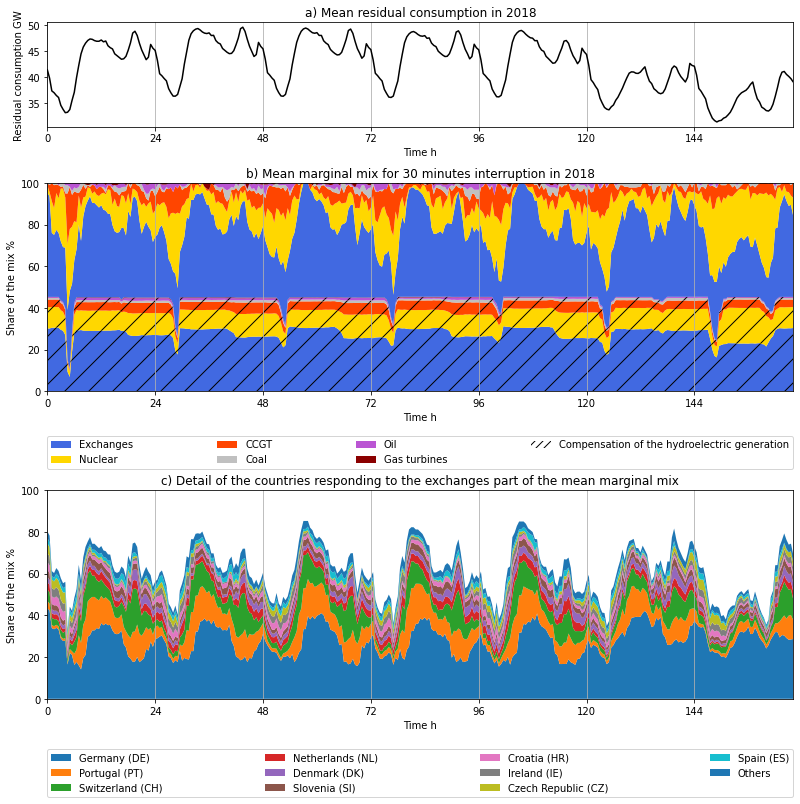

In [56]:
fig = plt.figure(constrained_layout=True,figsize=(11, 11))

gs = gridspec.GridSpec(5, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(conso_moy/1000, color='black')
ax1.grid(True, axis='x')
ax1.set_title('a) Mean residual consumption in 2018')
ax1.set_ylabel('Residual consumption GW')
ax1.set_xlabel('Time h')
ax1.xaxis.set_major_locator(MultipleLocator(24))
ax1.set_xlim(0,166)

ax4 = fig.add_subplot(gs[1:3, :])
stack=ax4.stackplot(mix_mean_30min.index,[(-mix_mean_30min[tech]).values for tech in list(mix_mean_30min)], colors=list_colors)
ax4.legend(handles=list_patch,bbox_to_anchor=(0., -0.37, 1, .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
for st in stack[0:6]:
    st.set_hatch('/')
ax4.grid(True, axis='x')
ax4.set_ylabel('Share of the mix %')
ax4.set_xlabel('Time h')
ax4.xaxis.set_major_locator(MultipleLocator(24))
ax4.set_xlim(0,166)
ax4.set_ylim(0,100)
ax4.set_title('b) Mean marginal mix for 30 minutes interruption in 2018')

ax5 = fig.add_subplot(gs[3:5, :])
stack=ax5.stackplot(mix_int_moy.index,[(mix_int_moy[tech]).values for tech in liste_pays], labels=liste_pays)
ax5.legend(bbox_to_anchor=(0., -0.47, 1, .102), loc='lower left',ncol=4, mode="expand", borderaxespad=0.)
ax5.grid(True, axis='x')
ax5.set_ylabel('Share of the mix %')
ax5.set_xlabel('Time h')
ax5.xaxis.set_major_locator(MultipleLocator(24))
ax5.set_xlim(0,166)
ax5.set_ylim(0,100)
ax5.set_title('c) Detail of the countries responding to the exchanges part of the mean marginal mix')

plt.show()
fig.savefig('Results\Plot\Week marg 30min.svg', format='svg')

In [58]:
#List with the weekly time-step corresponding to the minimum residual consumption each monday between 0am and 6am

list_t_min_w=pd.Series([df_resampled['Dispatchable'].loc[date:date+datetime.timedelta(hours=6)].idxmin() for date in pd.date_range(start=datetime.datetime(year,1,1), end=datetime.datetime(year,12,31), freq='7d')], index=pd.date_range(start=datetime.datetime(2018,1,1), end=datetime.datetime(2018,12,31), freq='7d'))

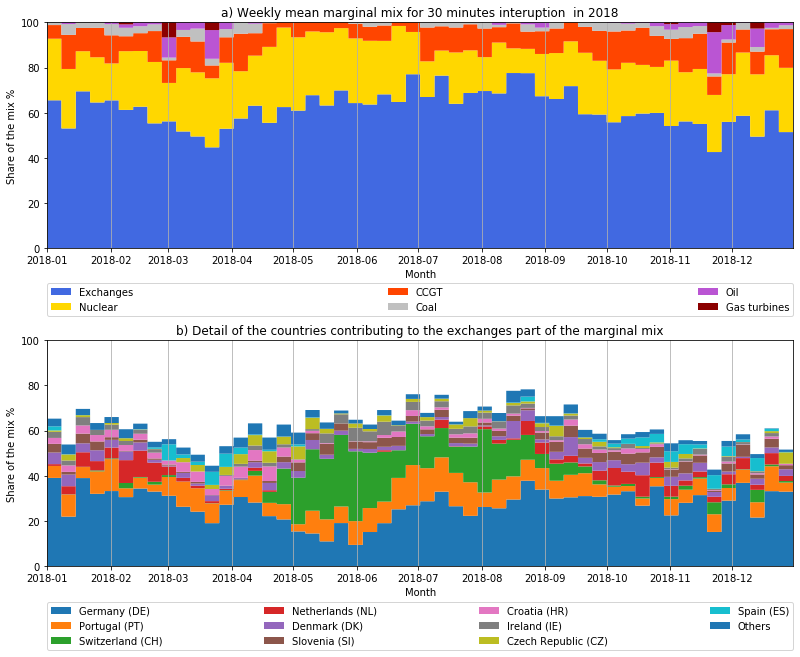

In [70]:
weeks=pd.date_range(start=datetime.datetime(year,1,1), end=datetime.datetime(year,12,24), freq='7d')
mix_moy_an_30=pd.DataFrame(columns=technos,  dtype = float)
for wix in weeks:
    for tech in list(mix_moy_an_30):
        mix_moy_an_30.at[wix,tech]=np.mean(MixMarg_30min.loc[list_t_min_w[wix]:list_t_min_w[wix+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30),tech])
        mix_moy_an_30.at[wix+datetime.timedelta(days=6,hours=23,minutes=30),tech]=np.mean(MixMarg_30min.loc[list_t_min_w[wix]:list_t_min_w[wix+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30),tech])
        
mix_moy_an_int=pd.DataFrame(columns=liste_pays,  dtype = float)
for wix in weeks:
    for tech in list(mix_moy_an_int):
        mix_moy_an_int.at[wix,tech]=-np.mean(MixMarg_30min.loc[wix:wix+datetime.timedelta(days=6,hours=23,minutes=30),'Ech. physiques']*df_interco.loc[wix:wix+datetime.timedelta(days=6,hours=23,minutes=30),tech])
        mix_moy_an_int.at[wix+datetime.timedelta(days=6,hours=23,minutes=30),tech]=-np.mean(MixMarg_30min.loc[wix:wix+datetime.timedelta(days=6,hours=23,minutes=30),'Ech. physiques']*df_interco.loc[wix:wix+datetime.timedelta(days=6,hours=23,minutes=30),tech])

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)
fig = plt.figure(constrained_layout=True,figsize=(11, 9))
gs = gridspec.GridSpec(4, 3, figure=fig)

ax4 = fig.add_subplot(gs[0:2, :])
stack=ax4.stackplot(mix_moy_an_30.index,[(-mix_moy_an_30[tech]).values for tech in list(mix_moy_an_30)], colors=list_colors)
ax4.legend(handles=list_patch[0:6],bbox_to_anchor=(0., -0.3, 1, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
ax4.grid(True, axis='x')
ax4.set_ylabel('Share of the mix %')
ax4.set_xlabel('Month')
ax4.set_xlim('2018-1-1','2018-12-30 23:30')
ax4.set_ylim(0,100)
ax4.set_title('a) Weekly mean marginal mix for 30 minutes interuption  in 2018')

ax5 = fig.add_subplot(gs[2:4, :])
ax5.stackplot(mix_moy_an_int.index,[(mix_moy_an_int[tech]).values for tech in liste_pays], labels=liste_pays)
ax5.legend(bbox_to_anchor=(0., -0.37, 1, .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
ax5.grid(True, axis='x')
ax5.set_ylabel('Share of the mix %')
ax5.set_xlabel('Month')
ax5.set_xlim('2018-1-1','2018-12-30 23:30')
ax5.set_ylim(0,100)
ax5.set_title('b) Detail of the countries contributing to the exchanges part of the marginal mix')

plt.show()
fig.savefig('Results\Plot\Annual marg 30min.svg', format='svg')

#### Marginal mix 6 hours

In [71]:
Flex_6hr=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=[d for wk in pd.date_range(start=s_date, end=e_date, freq='7d') for d in pd.date_range(start=wk+datetime.timedelta(hours=6), end =wk+datetime.timedelta(days=6, hours=18), freq='6h')])
MixMarg_6hr=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=[d for wk in pd.date_range(start=s_date, end=e_date, freq='7d') for d in pd.date_range(start=wk+datetime.timedelta(hours=6), end =wk+datetime.timedelta(days=6, hours=18), freq='6h')])
list_res=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco)
for wk in pd.date_range(start=s_date, end=e_date, freq='7d'):
    idx_wk=pd.date_range(start=list_t_min_date[wk]+datetime.timedelta(minutes=30), end =list_t_min_date[wk+datetime.timedelta(days=7)], freq='30min')
    idx_m=pd.date_range(start=wk+datetime.timedelta(hours=6), end =wk+datetime.timedelta(days=6, hours=18), freq='6h')
    for dte in idx_m:
        print(dte)
        MODEL_Dispatch_marg=pd.DataFrame(columns=['Hydraulique2', 'Nucleaire', 'Charbon', 'Ech. physiques', 'Gaz - CCGT', 'Gaz - TAC', 'Fioul - TAC', 'Fioul - Autres'], index=idx_wk, dtype = float)
        MODEL_Dispatch_marg['Hydraulique2']=f_hydro2(df_resampled['Dispatchable']+pd.Series([0 for d in df_resampled[datetime.datetime(year,1,1):dte-datetime.timedelta(minutes=30)].index]+[-100 for d in df_resampled[dte:dte+datetime.timedelta(hours=5, minutes=30)].index]+[0 for d in df_resampled[dte+datetime.timedelta(hours=6):datetime.datetime(year,12,31,23,30)].index], index=df_resampled.index),df_resampled['Hydraulique2'],wk)
        MODEL_D=mod_thermique2(df_resampled['Dispatchable']+pd.Series([0 for d in df_resampled[list_t_min_date[wk]+datetime.timedelta(minutes=30):dte-datetime.timedelta(minutes=30)].index]+[-100 for d in df_resampled[dte:dte+datetime.timedelta(hours=5, minutes=30)].index]+[0 for d in df_resampled[dte+datetime.timedelta(hours=6):list_t_min_date[wk+datetime.timedelta(days=7)]].index], index=idx_wk)-MODEL_Dispatch_marg['Hydraulique2']+df_ntc_export, wk)
        MODEL_Dispatch_marg.loc[:,'Charbon']=MODEL_D['Charbon_1']+MODEL_D['Charbon_2']+MODEL_D['Charbon_3']+MODEL_D['Charbon_4']+MODEL_D['Charbon_5']
        MODEL_Dispatch_marg.loc[:,'Gaz - CCGT']=MODEL_D['CCGT_1']+MODEL_D['CCGT_2']+MODEL_D['CCGT_3']+MODEL_D['CCGT_4']+MODEL_D['CCGT_5']+MODEL_D['CCGT_6']+MODEL_D['CCGT_7']+MODEL_D['CCGT_8']+MODEL_D['CCGT_9']+MODEL_D['CCGT_10']
        MODEL_Dispatch_marg.loc[:,'Nucleaire']=MODEL_D['Nucleaire - Base']+MODEL_D['Nucleaire_1']+MODEL_D['Nucleaire_2']+MODEL_D['Nucleaire_3']+MODEL_D['Nucleaire_4']+MODEL_D['Nucleaire_5']+MODEL_D['Nucleaire_6']
        MODEL_Dispatch_marg.loc[:,'Ech. physiques']=MODEL_D.loc[:,['Ech. p_'+repr(i) for i in range(1,n_EP)]].sum(axis=1)-df_ntc_export
        MODEL_Dispatch_marg.loc[:,'Gaz - TAC']=MODEL_D['Gaz - TAC']
        MODEL_Dispatch_marg.loc[:,'Fioul']=MODEL_D['Fioul - Autres']+MODEL_D['Fioul - TAC']
        mix_marg=MODEL_Dispatch_marg-MODEL_Dispatch
        for country in list(df_interco):
            mix_marg[country]=np.multiply(mix_marg['Ech. physiques'],df_interco[country])
        MixMarg_6hr.loc[dte, list_res]=((mix_marg[list_t_min_date[wk]+datetime.timedelta(minutes=30): list_t_min_date[wk+datetime.timedelta(days=7)]])/12).sum()
        Flex_6hr.loc[dte, :]=((mix_marg.loc[dte: dte+datetime.timedelta(hours=5,minutes=30),:])/12).sum() 

2018-01-01 06:00:00
2018-01-01 12:00:00
2018-01-01 18:00:00
2018-01-02 00:00:00
2018-01-02 06:00:00
2018-01-02 12:00:00
2018-01-02 18:00:00
2018-01-03 00:00:00
2018-01-03 06:00:00
2018-01-03 12:00:00
2018-01-03 18:00:00
2018-01-04 00:00:00
2018-01-04 06:00:00
2018-01-04 12:00:00
2018-01-04 18:00:00
2018-01-05 00:00:00
2018-01-05 06:00:00
2018-01-05 12:00:00
2018-01-05 18:00:00
2018-01-06 00:00:00
2018-01-06 06:00:00
2018-01-06 12:00:00
2018-01-06 18:00:00
2018-01-07 00:00:00
2018-01-07 06:00:00
2018-01-07 12:00:00
2018-01-07 18:00:00
2018-01-08 06:00:00
2018-01-08 12:00:00
2018-01-08 18:00:00
2018-01-09 00:00:00
2018-01-09 06:00:00
2018-01-09 12:00:00
2018-01-09 18:00:00
2018-01-10 00:00:00
2018-01-10 06:00:00
2018-01-10 12:00:00
2018-01-10 18:00:00
2018-01-11 00:00:00
2018-01-11 06:00:00
2018-01-11 12:00:00
2018-01-11 18:00:00
2018-01-12 00:00:00
2018-01-12 06:00:00
2018-01-12 12:00:00
2018-01-12 18:00:00
2018-01-13 00:00:00
2018-01-13 06:00:00
2018-01-13 12:00:00
2018-01-13 18:00:00


2018-04-17 12:00:00
2018-04-17 18:00:00
2018-04-18 00:00:00
2018-04-18 06:00:00
2018-04-18 12:00:00
2018-04-18 18:00:00
2018-04-19 00:00:00
2018-04-19 06:00:00
2018-04-19 12:00:00
2018-04-19 18:00:00
2018-04-20 00:00:00
2018-04-20 06:00:00
2018-04-20 12:00:00
2018-04-20 18:00:00
2018-04-21 00:00:00
2018-04-21 06:00:00
2018-04-21 12:00:00
2018-04-21 18:00:00
2018-04-22 00:00:00
2018-04-22 06:00:00
2018-04-22 12:00:00
2018-04-22 18:00:00
2018-04-23 06:00:00
2018-04-23 12:00:00
2018-04-23 18:00:00
2018-04-24 00:00:00
2018-04-24 06:00:00
2018-04-24 12:00:00
2018-04-24 18:00:00
2018-04-25 00:00:00
2018-04-25 06:00:00
2018-04-25 12:00:00
2018-04-25 18:00:00
2018-04-26 00:00:00
2018-04-26 06:00:00
2018-04-26 12:00:00
2018-04-26 18:00:00
2018-04-27 00:00:00
2018-04-27 06:00:00
2018-04-27 12:00:00
2018-04-27 18:00:00
2018-04-28 00:00:00
2018-04-28 06:00:00
2018-04-28 12:00:00
2018-04-28 18:00:00
2018-04-29 00:00:00
2018-04-29 06:00:00
2018-04-29 12:00:00
2018-04-29 18:00:00
2018-04-30 06:00:00


2018-08-01 18:00:00
2018-08-02 00:00:00
2018-08-02 06:00:00
2018-08-02 12:00:00
2018-08-02 18:00:00
2018-08-03 00:00:00
2018-08-03 06:00:00
2018-08-03 12:00:00
2018-08-03 18:00:00
2018-08-04 00:00:00
2018-08-04 06:00:00
2018-08-04 12:00:00
2018-08-04 18:00:00
2018-08-05 00:00:00
2018-08-05 06:00:00
2018-08-05 12:00:00
2018-08-05 18:00:00
2018-08-06 06:00:00
2018-08-06 12:00:00
2018-08-06 18:00:00
2018-08-07 00:00:00
2018-08-07 06:00:00
2018-08-07 12:00:00
2018-08-07 18:00:00
2018-08-08 00:00:00
2018-08-08 06:00:00
2018-08-08 12:00:00
2018-08-08 18:00:00
2018-08-09 00:00:00
2018-08-09 06:00:00
2018-08-09 12:00:00
2018-08-09 18:00:00
2018-08-10 00:00:00
2018-08-10 06:00:00
2018-08-10 12:00:00
2018-08-10 18:00:00
2018-08-11 00:00:00
2018-08-11 06:00:00
2018-08-11 12:00:00
2018-08-11 18:00:00
2018-08-12 00:00:00
2018-08-12 06:00:00
2018-08-12 12:00:00
2018-08-12 18:00:00
2018-08-13 06:00:00
2018-08-13 12:00:00
2018-08-13 18:00:00
2018-08-14 00:00:00
2018-08-14 06:00:00
2018-08-14 12:00:00


2018-11-16 00:00:00
2018-11-16 06:00:00
2018-11-16 12:00:00
2018-11-16 18:00:00
2018-11-17 00:00:00
2018-11-17 06:00:00
2018-11-17 12:00:00
2018-11-17 18:00:00
2018-11-18 00:00:00
2018-11-18 06:00:00
2018-11-18 12:00:00
2018-11-18 18:00:00
2018-11-19 06:00:00
2018-11-19 12:00:00
2018-11-19 18:00:00
2018-11-20 00:00:00
2018-11-20 06:00:00
2018-11-20 12:00:00
2018-11-20 18:00:00
2018-11-21 00:00:00
2018-11-21 06:00:00
2018-11-21 12:00:00
2018-11-21 18:00:00
2018-11-22 00:00:00
2018-11-22 06:00:00
2018-11-22 12:00:00
2018-11-22 18:00:00
2018-11-23 00:00:00
2018-11-23 06:00:00
2018-11-23 12:00:00
2018-11-23 18:00:00
2018-11-24 00:00:00
2018-11-24 06:00:00
2018-11-24 12:00:00
2018-11-24 18:00:00
2018-11-25 00:00:00
2018-11-25 06:00:00
2018-11-25 12:00:00
2018-11-25 18:00:00
2018-11-26 06:00:00
2018-11-26 12:00:00
2018-11-26 18:00:00
2018-11-27 00:00:00
2018-11-27 06:00:00
2018-11-27 12:00:00
2018-11-27 18:00:00
2018-11-28 00:00:00
2018-11-28 06:00:00
2018-11-28 12:00:00
2018-11-28 18:00:00


In [72]:
Flex_6hr.to_csv('Results\Data\Flexibility_2018_6h.csv')
MixMarg_6hr.to_csv('Results\Data\MarginalMix_2018_6h.csv')

#### Marginal mix  half-day

In [43]:
Flex_12hr=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=[d for wk in pd.date_range(start=s_date, end=e_date, freq='7d') for d in pd.date_range(start=wk, end =wk+datetime.timedelta(days=6, hours=23), freq='12h')])
MixMarg_12hr=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=[d for wk in pd.date_range(start=s_date, end=e_date, freq='7d') for d in pd.date_range(start=wk, end =wk+datetime.timedelta(days=6, hours=23), freq='12h')])
list_res=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco)
for wk in pd.date_range(start=s_date, end=e_date, freq='7d'):
    idx_wk=pd.date_range(start=list_t_min_date[wk]+datetime.timedelta(minutes=30), end =list_t_min_date[wk+datetime.timedelta(days=7)], freq='30min')
    idx_m=pd.date_range(start=wk, end =wk+datetime.timedelta(days=6, hours=23), freq='12h')
    for dte in idx_m:
        print(dte)
        MODEL_Dispatch_marg=pd.DataFrame(columns=['Hydraulique2', 'Nucleaire', 'Charbon', 'Ech. physiques', 'Gaz - CCGT', 'Gaz - TAC', 'Fioul - TAC', 'Fioul - Autres'], index=idx_wk, dtype = float)
        MODEL_Dispatch_marg['Hydraulique2']=f_hydro2(df_resampled['Dispatchable']+pd.Series([0 for d in df_resampled[datetime.datetime(2018,1,1):list_t_min_12[dte]-datetime.timedelta(minutes=30)].index]+[-100 for d in df_resampled[list_t_min_12[dte]:list_t_min_12[dte+datetime.timedelta(hours=12)]-datetime.timedelta(minutes=30)].index]+[0 for d in df_resampled[list_t_min_12[dte+datetime.timedelta(hours=12)]:datetime.datetime(2018,12,31,23,30)].index], index=df_resampled.index),df_resampled['Hydraulique2'],wk)
        MODEL_D=mod_thermique2(df_resampled['Dispatchable']+pd.Series([0 for d in df_resampled[list_t_min_12[wk]+datetime.timedelta(minutes=30):list_t_min_12[dte]].index]+[-100 for d in df_resampled[list_t_min_12[dte]+datetime.timedelta(minutes=30):list_t_min_12[dte+datetime.timedelta(hours=12)]].index]+[0 for d in df_resampled[list_t_min_12[dte+datetime.timedelta(hours=12)]+datetime.timedelta(minutes=30):list_t_min_12[wk+datetime.timedelta(days=7)]].index], index=idx_wk)-MODEL_Dispatch_marg['Hydraulique2']+df_ntc_export, wk)
        MODEL_Dispatch_marg.loc[:,'Charbon']=MODEL_D['Charbon_1']+MODEL_D['Charbon_2']+MODEL_D['Charbon_3']+MODEL_D['Charbon_4']+MODEL_D['Charbon_5']
        MODEL_Dispatch_marg.loc[:,'Gaz - CCGT']=MODEL_D['CCGT_1']+MODEL_D['CCGT_2']+MODEL_D['CCGT_3']+MODEL_D['CCGT_4']+MODEL_D['CCGT_5']+MODEL_D['CCGT_6']+MODEL_D['CCGT_7']+MODEL_D['CCGT_8']+MODEL_D['CCGT_9']+MODEL_D['CCGT_10']
        MODEL_Dispatch_marg.loc[:,'Nucleaire']=MODEL_D['Nucleaire - Base']+MODEL_D['Nucleaire_1']+MODEL_D['Nucleaire_2']+MODEL_D['Nucleaire_3']+MODEL_D['Nucleaire_4']+MODEL_D['Nucleaire_5']+MODEL_D['Nucleaire_6']
        MODEL_Dispatch_marg.loc[:,'Ech. physiques']=MODEL_D.loc[:,['Ech. p_'+repr(i) for i in range(1,n_EP)]].sum(axis=1)-df_ntc_export
        MODEL_Dispatch_marg.loc[:,'Fioul']=MODEL_D['Fioul - TAC']+MODEL_D['Fioul - Autres']
        MODEL_Dispatch_marg.loc[:,'Gaz - TAC']=MODEL_D['Gaz - TAC']
        mix_marg=MODEL_Dispatch_marg-MODEL_Dispatch
        n_ts=sum([-100 for d in df_resampled[list_t_min_12[dte]+datetime.timedelta(minutes=30):list_t_min_12[dte+datetime.timedelta(hours=12)]].index])
        for country in list(df_interco):
            mix_marg[country]=np.multiply(mix_marg['Ech. physiques'],df_interco[country])
        MixMarg_12hr.loc[dte, list_res]=(mix_marg[list_t_min_date[wk]+datetime.timedelta(minutes=30): list_t_min_date[wk+datetime.timedelta(days=7)]]).sum()/n_ts
        Flex_12hr.loc[dte, :]=mix_marg[list_t_min_12[dte]+datetime.timedelta(minutes=30): list_t_min_12[dte+datetime.timedelta(hours=12)]].sum()/n_ts


2018-01-01 00:00:00
2018-01-01 12:00:00
2018-01-02 00:00:00
2018-01-02 12:00:00
2018-01-03 00:00:00
2018-01-03 12:00:00
2018-01-04 00:00:00
2018-01-04 12:00:00
2018-01-05 00:00:00
2018-01-05 12:00:00
2018-01-06 00:00:00
2018-01-06 12:00:00
2018-01-07 00:00:00
2018-01-07 12:00:00
2018-01-08 00:00:00
2018-01-08 12:00:00
2018-01-09 00:00:00
2018-01-09 12:00:00
2018-01-10 00:00:00
2018-01-10 12:00:00
2018-01-11 00:00:00
2018-01-11 12:00:00
2018-01-12 00:00:00
2018-01-12 12:00:00
2018-01-13 00:00:00
2018-01-13 12:00:00
2018-01-14 00:00:00
2018-01-14 12:00:00
2018-01-15 00:00:00
2018-01-15 12:00:00
2018-01-16 00:00:00
2018-01-16 12:00:00
2018-01-17 00:00:00
2018-01-17 12:00:00
2018-01-18 00:00:00
2018-01-18 12:00:00
2018-01-19 00:00:00
2018-01-19 12:00:00
2018-01-20 00:00:00
2018-01-20 12:00:00
2018-01-21 00:00:00
2018-01-21 12:00:00
2018-01-22 00:00:00
2018-01-22 12:00:00
2018-01-23 00:00:00
2018-01-23 12:00:00
2018-01-24 00:00:00
2018-01-24 12:00:00
2018-01-25 00:00:00
2018-01-25 12:00:00


2018-07-25 00:00:00
2018-07-25 12:00:00
2018-07-26 00:00:00
2018-07-26 12:00:00
2018-07-27 00:00:00
2018-07-27 12:00:00
2018-07-28 00:00:00
2018-07-28 12:00:00
2018-07-29 00:00:00
2018-07-29 12:00:00
2018-07-30 00:00:00
2018-07-30 12:00:00
2018-07-31 00:00:00
2018-07-31 12:00:00
2018-08-01 00:00:00
2018-08-01 12:00:00
2018-08-02 00:00:00
2018-08-02 12:00:00
2018-08-03 00:00:00
2018-08-03 12:00:00
2018-08-04 00:00:00
2018-08-04 12:00:00
2018-08-05 00:00:00
2018-08-05 12:00:00
2018-08-06 00:00:00
2018-08-06 12:00:00
2018-08-07 00:00:00
2018-08-07 12:00:00
2018-08-08 00:00:00
2018-08-08 12:00:00
2018-08-09 00:00:00
2018-08-09 12:00:00
2018-08-10 00:00:00
2018-08-10 12:00:00
2018-08-11 00:00:00
2018-08-11 12:00:00
2018-08-12 00:00:00
2018-08-12 12:00:00
2018-08-13 00:00:00
2018-08-13 12:00:00
2018-08-14 00:00:00
2018-08-14 12:00:00
2018-08-15 00:00:00
2018-08-15 12:00:00
2018-08-16 00:00:00
2018-08-16 12:00:00
2018-08-17 00:00:00
2018-08-17 12:00:00
2018-08-18 00:00:00
2018-08-18 12:00:00


In [54]:
Flex_12hr.to_csv('Results\Data\Flexibility_2018_halfday.csv')
MixMarg_12hr.to_csv('Results\Data\MarginalMix_2018_halfday.csv')

#### Marginal mix day

In [55]:
Flex_day=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=pd.date_range(start=s_date, end=e_date))
MixMarg_day=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=pd.date_range(start=s_date, end=e_date))
list_res=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco)
for wk in pd.date_range(start=s_date, end=e_date, freq='7d'):
    idx_wk=pd.date_range(start=list_t_min_date[wk]+datetime.timedelta(minutes=30), end =list_t_min_date[wk+datetime.timedelta(days=7)], freq='30min')
    idx_m=pd.date_range(start=wk, end =wk+datetime.timedelta(days=6, hours=23), freq='1d')
    for dte in idx_m:
        print(dte)
        MODEL_Dispatch_marg=pd.DataFrame(columns=['Hydraulique2', 'Nucleaire', 'Charbon', 'Ech. physiques', 'Gaz - CCGT', 'Gaz - TAC', 'Fioul - TAC', 'Fioul - Autres'], index=idx_wk, dtype = float)
        MODEL_Dispatch_marg['Hydraulique2']=f_hydro2(df_resampled['Dispatchable']+pd.Series([0 for d in df_resampled[datetime.datetime(2018,1,1):list_t_min_date[dte]].index]+[-100 for d in df_resampled[list_t_min_date[dte]+datetime.timedelta(minutes=30):list_t_min_12[dte+datetime.timedelta(days=1)]].index]+[0 for d in df_resampled[list_t_min_date[dte+datetime.timedelta(days=1)]+datetime.timedelta(minutes=30):datetime.datetime(2018,12,31,23,30)].index], index=df_resampled.index),df_resampled['Hydraulique2'],wk)
        MODEL_D=mod_thermique3(df_resampled['Dispatchable']+pd.Series([0 for d in df_resampled[list_t_min_12[wk]+datetime.timedelta(minutes=30):list_t_min_date[dte]].index]+[-100 for d in df_resampled[list_t_min_date[dte]+datetime.timedelta(minutes=30):list_t_min_12[dte+datetime.timedelta(days=1)]].index]+[0 for d in df_resampled[list_t_min_date[dte+datetime.timedelta(days=1)]+datetime.timedelta(minutes=30):list_t_min_date[wk+datetime.timedelta(days=7)]].index], index=idx_wk)-MODEL_Dispatch_marg['Hydraulique2']+df_ntc_export, wk)
        MODEL_Dispatch_marg.loc[:,'Charbon']=MODEL_D['Charbon_1']+MODEL_D['Charbon_2']+MODEL_D['Charbon_3']+MODEL_D['Charbon_4']+MODEL_D['Charbon_5']
        MODEL_Dispatch_marg.loc[:,'Gaz - CCGT']=MODEL_D['CCGT_1']+MODEL_D['CCGT_2']+MODEL_D['CCGT_3']+MODEL_D['CCGT_4']+MODEL_D['CCGT_5']+MODEL_D['CCGT_6']+MODEL_D['CCGT_7']+MODEL_D['CCGT_8']+MODEL_D['CCGT_9']+MODEL_D['CCGT_10']
        MODEL_Dispatch_marg.loc[:,'Nucleaire']=MODEL_D['Nucleaire - Base']+MODEL_D['Nucleaire_1']+MODEL_D['Nucleaire_2']+MODEL_D['Nucleaire_3']+MODEL_D['Nucleaire_4']+MODEL_D['Nucleaire_5']+MODEL_D['Nucleaire_6']
        MODEL_Dispatch_marg.loc[:,'Ech. physiques']=MODEL_D.loc[:,['Ech. p_'+repr(i) for i in range(1,n_EP)]].sum(axis=1)-df_ntc_export
        MODEL_Dispatch_marg.loc[:,'Fioul']=MODEL_D['Fioul - TAC']+MODEL_D['Fioul - Autres']
        MODEL_Dispatch_marg.loc[:,'Gaz - TAC']=MODEL_D['Gaz - TAC']
        mix_marg=MODEL_Dispatch_marg-MODEL_Dispatch
        n_ts=sum([-100 for d in df_resampled[list_t_min_date[dte]+datetime.timedelta(minutes=30):list_t_min_date[dte+datetime.timedelta(days=1)]].index])
        for country in list(df_interco):
            mix_marg[country]=np.multiply(mix_marg['Ech. physiques'],df_interco[country])
        MixMarg_day.loc[dte, list_res]=(mix_marg[list_t_min_date[wk]+datetime.timedelta(minutes=30): list_t_min_date[wk+datetime.timedelta(days=7)]]).sum()/n_ts
        Flex_day.loc[dte, list_tech]=mix_marg[list_t_min_date[dte]+datetime.timedelta(minutes=30): list_t_min_date[dte+datetime.timedelta(days=1)]].sum()/n_ts

2018-01-01 00:00:00
2018-01-02 00:00:00
2018-01-03 00:00:00
2018-01-04 00:00:00
2018-01-05 00:00:00
2018-01-06 00:00:00
2018-01-07 00:00:00
2018-01-08 00:00:00
2018-01-09 00:00:00
2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00


In [56]:
Flex_day.to_csv('Results\Data\Flexibility_2018_day.csv')
MixMarg_day.to_csv('Results\Data\MarginalMix_2018_day.csv')

In [ ]:
mix_moy_an_d

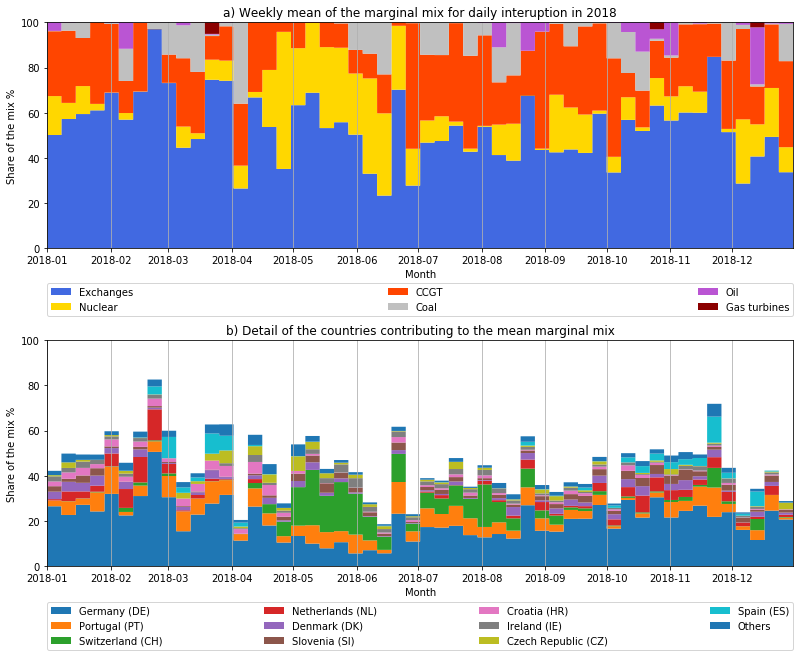

In [59]:
weeks=pd.date_range(start=datetime.datetime(year,1,1), end=datetime.datetime(year,12,24), freq='7d')
mix_moy_an_d=pd.DataFrame(columns=technos,  dtype = float)
for wix in weeks:
    for tech in list(mix_moy_an_d):
        #conso_moy[date]=np.mean(df_resampled.loc[pd.date_range(start=datetime.datetime(year,1,1)+datetime.timedelta(minutes=60*date), end=datetime.datetime(year,12,24,3,30),freq='7d'),'Dispatchable'])
        mix_moy_an_d.at[wix,tech]=100*np.mean(MixMarg_day.loc[list_t_min_w[wix]:list_t_min_w[wix+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30),tech])
        mix_moy_an_d.at[wix+datetime.timedelta(days=6,hours=23,minutes=30),tech]=100*np.mean(MixMarg_day.loc[list_t_min_w[wix]:list_t_min_w[wix+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30),tech])
        
inter_d=pd.DataFrame(columns=list(df_interco),index=Flex_day.index)
for date in Flex_day.index:
    for country in list(df_interco):
        inter_d.at[date, country]=np.mean(df_interco.loc[date+datetime.timedelta(hours=6):date+datetime.timedelta(hours=29.5),country])
        
mix_moy_an_int_d=pd.DataFrame(columns=liste_pays,  dtype = float)
for wix in weeks:
    for tech in list(mix_moy_an_int_d):
        mix_moy_an_int_d.at[wix,tech]=100*np.mean(Flex_day.loc[list_t_min_w[wix]:list_t_min_w[wix+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30),'Ech. physiques']*inter_d.loc[list_t_min_w[wix]:list_t_min_w[wix+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30),tech])
        mix_moy_an_int_d.at[wix+datetime.timedelta(days=6,hours=23,minutes=30),tech]=100*np.mean(Flex_day.loc[list_t_min_w[wix]:list_t_min_w[wix+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30),'Ech. physiques']*inter_d.loc[list_t_min_w[wix]:list_t_min_w[wix+datetime.timedelta(days=7)]-datetime.timedelta(minutes=30),tech])


def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)
fig = plt.figure(constrained_layout=True,figsize=(11, 9))
gs = gridspec.GridSpec(4, 3, figure=fig)

ax4 = fig.add_subplot(gs[0:2, :])
stack=ax4.stackplot(mix_moy_an_d.index,[(mix_moy_an_d[tech]).values for tech in list(mix_moy_an_d)], colors=list_colors)
ax4.legend(handles=list_patch[0:6],bbox_to_anchor=(0., -0.30, 1, .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
ax4.grid(True, axis='x')
ax4.set_ylabel('Share of the mix %')
ax4.set_xlabel('Month')
ax4.set_ylim(0,100)
ax4.set_xlim('2018-1-1','2018-12-30 23:30')
ax4.set_title('a) Weekly mean of the marginal mix for daily interuption in 2018')
           
ax5 = fig.add_subplot(gs[2:4, :])
ax5.stackplot(mix_moy_an_int_d.index,[(mix_moy_an_int_d[tech]).values for tech in liste_pays], labels=liste_pays)
ax5.legend(bbox_to_anchor=(0., -0.37, 1, .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
ax5.grid(True, axis='x')
ax5.set_ylabel('Share of the mix %')
ax5.set_xlabel('Month')
ax5.set_ylim(0,100)
ax5.set_xlim('2018-1-1','2018-12-30 23:30')
ax5.set_title('b) Detail of the countries contributing to the mean marginal mix')
           
plt.show()
fig.savefig('Results\Plot\Annual marg day.svg', format='svg')

#### Marginal mix week

In [60]:
Flex_week=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=pd.date_range(start=s_date, end=e_date, freq='7d'))
MixMarg_week=pd.DataFrame(columns=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco),index=pd.date_range(start=s_date, end=e_date, freq='7d'))
list_res=['Hydraulique2', 'Charbon','Gaz - CCGT','Nucleaire','Ech. physiques','Fioul', 'Gaz - TAC']+list(df_interco)
for wk in pd.date_range(start=s_date, end=e_date, freq='7d'):
    dte=wk
    print(wk)
    idx_wk=pd.date_range(start=list_t_min_date[wk]+datetime.timedelta(minutes=30), end =list_t_min_date[wk+datetime.timedelta(days=7)], freq='30min')
    MODEL_Dispatch_marg=pd.DataFrame(columns=['Hydraulique2', 'Nucleaire', 'Charbon', 'Ech. physiques', 'Gaz - CCGT', 'Gaz - TAC', 'Fioul - TAC', 'Fioul - Autres'], index=idx_wk, dtype = float)
    MODEL_Dispatch_marg['Hydraulique2']=f_hydro2(df_resampled['Dispatchable']+pd.Series([0 for d in df_resampled[datetime.datetime(2018,1,1):list_t_min_date[dte]].index]+[-100 for d in df_resampled[list_t_min_date[dte]+datetime.timedelta(minutes=30):list_t_min_12[dte+datetime.timedelta(days=7)]].index]+[0 for d in df_resampled[list_t_min_date[dte+datetime.timedelta(days=7)]+datetime.timedelta(minutes=30):datetime.datetime(2018,12,31,23,30)].index], index=df_resampled.index),df_resampled['Hydraulique2'],wk)
    MODEL_D=mod_thermique3(df_resampled['Dispatchable']+pd.Series(-100, index=idx_wk)-MODEL_Dispatch_marg['Hydraulique2']+df_ntc_export, wk)
    MODEL_Dispatch_marg.loc[:,'Charbon']=MODEL_D['Charbon_1']+MODEL_D['Charbon_2']+MODEL_D['Charbon_3']+MODEL_D['Charbon_4']+MODEL_D['Charbon_5']
    MODEL_Dispatch_marg.loc[:,'Gaz - CCGT']=MODEL_D['CCGT_1']+MODEL_D['CCGT_2']+MODEL_D['CCGT_3']+MODEL_D['CCGT_4']+MODEL_D['CCGT_5']+MODEL_D['CCGT_6']+MODEL_D['CCGT_7']+MODEL_D['CCGT_8']+MODEL_D['CCGT_9']+MODEL_D['CCGT_10']
    MODEL_Dispatch_marg.loc[:,'Nucleaire']=MODEL_D['Nucleaire - Base']+MODEL_D['Nucleaire_1']+MODEL_D['Nucleaire_2']+MODEL_D['Nucleaire_3']+MODEL_D['Nucleaire_4']+MODEL_D['Nucleaire_5']+MODEL_D['Nucleaire_6']
    MODEL_Dispatch_marg.loc[:,'Ech. physiques']=MODEL_D.loc[:,['Ech. p_'+repr(i) for i in range(1,n_EP)]].sum(axis=1)-df_ntc_export
    MODEL_Dispatch_marg.loc[:,'Fioul']=MODEL_D['Fioul - TAC']+MODEL_D['Fioul - Autres']
    MODEL_Dispatch_marg.loc[:,'Gaz - TAC']=MODEL_D['Gaz - TAC']
    mix_marg=MODEL_Dispatch_marg-MODEL_Dispatch
    n_ts=sum([-100 for d in idx_wk])
    for country in list(df_interco):
        mix_marg[country]=np.multiply(mix_marg['Ech. physiques'],df_interco[country])
    MixMarg_week.loc[dte, list_res]=(mix_marg[list_t_min_date[wk]+datetime.timedelta(minutes=30): list_t_min_date[wk+datetime.timedelta(days=7)]]).sum()/n_ts
 

2018-01-01 00:00:00
2018-01-08 00:00:00
2018-01-15 00:00:00
2018-01-22 00:00:00
2018-01-29 00:00:00
2018-02-05 00:00:00
2018-02-12 00:00:00
2018-02-19 00:00:00
2018-02-26 00:00:00
2018-03-05 00:00:00
2018-03-12 00:00:00
2018-03-19 00:00:00
2018-03-26 00:00:00
2018-04-02 00:00:00
2018-04-09 00:00:00
2018-04-16 00:00:00
2018-04-23 00:00:00
2018-04-30 00:00:00
2018-05-07 00:00:00
2018-05-14 00:00:00
2018-05-21 00:00:00
2018-05-28 00:00:00
2018-06-04 00:00:00
2018-06-11 00:00:00
2018-06-18 00:00:00
2018-06-25 00:00:00
2018-07-02 00:00:00
2018-07-09 00:00:00
2018-07-16 00:00:00
2018-07-23 00:00:00
2018-07-30 00:00:00
2018-08-06 00:00:00
2018-08-13 00:00:00
2018-08-20 00:00:00
2018-08-27 00:00:00
2018-09-03 00:00:00
2018-09-10 00:00:00
2018-09-17 00:00:00
2018-09-24 00:00:00
2018-10-01 00:00:00
2018-10-08 00:00:00
2018-10-15 00:00:00
2018-10-22 00:00:00
2018-10-29 00:00:00
2018-11-05 00:00:00
2018-11-12 00:00:00
2018-11-19 00:00:00
2018-11-26 00:00:00
2018-12-03 00:00:00
2018-12-10 00:00:00


In [61]:
Flex_week.to_csv('Results\Data\Flexibility_2018_week.csv')

#### Summary of the marginal mix results

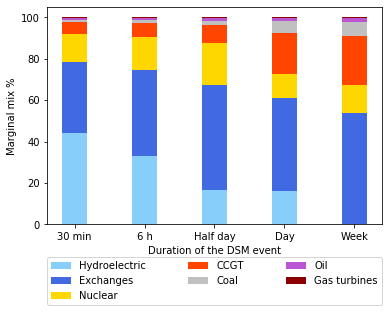

In [73]:
labels=pd.Series(['Hydroelectric','Exchanges','Nuclear','CCGT','Coal', 'Oil', 'Gas turbines'], index=['Hydraulique2','Ech. physiques','Nucleaire', 'Gaz - CCGT','Charbon','Fioul', 'Gaz - TAC'])
Serie_colors=pd.Series(['lightskyblue']+list_colors, index=labels.index)

MixMargAn_f=pd.DataFrame(index=labels.index, columns=['30min', '6h', 'demijour', 'jour', 'semaine'],  dtype = float)
width=0.35
durees=['30 min', '6 h', 'Half day', 'Day', 'Week']
MixMargAn_f['30min']=-np.mean(Flex_30min.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,24,3,30),labels.index])
MixMargAn_f['6h']=-np.mean(Flex_6hr.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,24,3,30),labels.index])
MixMargAn_f['demijour']=np.mean(Flex_12hr.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,24,3,30),labels.index])*100
MixMargAn_f['jour']=np.mean(Flex_day.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,23),labels.index])*100
MixMargAn_f['semaine']=np.mean(MixMarg_week.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,17),labels.index])*100

fig, ax = plt.subplots()
i=0
for techno in labels.index:
    ax.bar(durees, MixMargAn_f.loc[techno,:], width,bottom=MixMargAn_f.loc[(labels.index)[0:i],:].sum(),  label=labels[techno], color=Serie_colors[techno])    
    i=i+1
    
ax.set_ylabel('Marginal mix %')
ax.set_xlabel('Duration of the DSM event')
ax.legend(bbox_to_anchor=(0, -0.37, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0.)
fig.savefig('Results\Plot\mix marg sans compensation by duration.svg', format='svg', bbox_inches="tight")

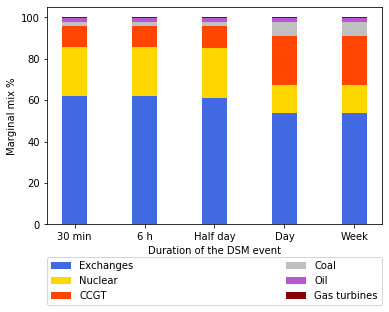

In [74]:
labels=pd.Series(['Exchanges','Nuclear','CCGT','Coal', 'Oil', 'Gas turbines'], index=['Ech. physiques','Nucleaire', 'Gaz - CCGT','Charbon','Fioul', 'Gaz - TAC'])

MixMargAn_f=pd.DataFrame(index=labels.index, columns=['30min', '6h', 'demijour', 'jour', 'semaine'],  dtype = float)
width=0.35
durees=['30 min', '6 h', 'Half day', 'Day', 'Week']
MixMargAn_f['30min']=-np.mean(MixMarg_30min.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,24,3,30),labels.index])
MixMargAn_f['6h']=-np.mean(MixMarg_6hr.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,24,3,30),labels.index])
MixMargAn_f['demijour']=np.mean(MixMarg_12hr.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,24,3,30),labels.index])*100
MixMargAn_f['jour']=np.mean(MixMarg_day.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,23),labels.index])*100
MixMargAn_f['semaine']=np.mean(MixMarg_week.loc[datetime.datetime(year,1,1,5):datetime.datetime(year,12,17),labels.index])*100

fig, ax = plt.subplots()
i=0
for techno in labels.index:
    ax.bar(durees, MixMargAn_f.loc[techno,:], width,bottom=MixMargAn_f.loc[labels.index[0:i],:].sum(),  label=labels[techno], color=Serie_colors[techno])    
    i=i+1
    
ax.set_ylabel('Marginal mix %')
ax.set_xlabel('Duration of the DSM event')
ax.legend(bbox_to_anchor=(0, -0.37, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
fig.savefig('Results\Plot\mix marg by duration.svg', format='svg', bbox_inches="tight")
